## 요약
- XGB를 이용하여 여러가지 상황에서의 성능 확인
- hyperparameter 차이에 따른 성능 차이
  - grid search 이용해서 찾은 hyperparameter가 default일 때보다 성능이 다소 우위
- train set에 SalesPoint를 포함 했을 때와 포함하지 않았을 때
  - SalesPoint
- val, test set 전체에서의 성능과, train에 포함된 적 없는 도서에 대한 데이터로 제한했을 때의 성능
  - hyperparameter가 default일 때의 성능이 다소 우위

In [1]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [2]:
from itertools import repeat, chain

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("fivethirtyeight")
# 이미지가 레이아웃 안으로 들어오도록 함
mpl.rcParams.update({"figure.constrained_layout.use": True})
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [4]:
#cd /content/drive/MyDrive/AI3_prjct2_aladin/

In [5]:
cd /content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2/

[Errno 2] No such file or directory: '/content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2/'
/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/research


In [3]:
# 로컬에서

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
#PRJCT_PATH = '/content/drive/MyDrive/WASSUP-ESTsoft-AI/project/project2/'
#PRJCT_PATH = '/content/drive/MyDrive/AI3_prjct2_aladin/aladin_usedbook/'
save_dir = 'processed/model_input'
dir_path = os.path.join(PRJCT_PATH,save_dir)
#dir_path = './'

In [5]:
ls

240710_crawling_step0.ipynb           240717_split_and_scale.ipynb
240711_crawling_step1.ipynb           240718_step0_by_js.ipynb
240711_preprocess_bookinfo.ipynb      240719_additional_eda.ipynb
240715_encoding_usedinfo.ipynb        240719_simple_model_for_cropped.ipynb
240716_check_bookinfo.ipynb           240721_GridSearch_for_XGB.ipynb
240716_check_bookinfo2.ipynb          240721_experiment_w_XGB.ipynb
240716_encoding_bookinfo.ipynb        240721_hyperparameters_XGB.ipynb
240717_simple_model_for_sample.ipynb


In [6]:
import sys
sys.path.append(PRJCT_PATH)

In [7]:
import re
def erase_num_comma(text):
    pat = r'\d\,\d'
    idx_list = sorted([m.start()+1 for m in re.finditer(pat,text)])
    temp = list(text)
    for i in idx_list[::-1]:
        temp.pop(i)
    return ''.join(temp)

In [8]:
import pickle

def save_pkl(save_dir,file_name,save_object):
    if not os.path.exists(save_dir): os.mkdirs(save_dir)
    file_path = os.path.join(save_dir,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(save_object,f)


def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)

    return data

- (0,5) : category
- (5,35) : BName
- (35,60) : BName_sub

In [9]:
## FUNCTIONS - DATA- SCORE REG RSLT

def mase_nontime(actual,pred,base_pred) -> np.ndarray:
    """
    MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    :param forecast: Forecast values. Shape: batch, time_o
    :param insample: Insample values. Shape: batch, time_i
    :param outsample: Target values. Shape: batch, time_o
    :param frequency: Frequency value
    :return: Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(actual - pred)) / np.mean(np.abs(actual - base_pred),)

def make_reg_score_dict(y_actual,y_pred,y_base=None):
    if y_base is None : y_base = np.mean(y_actual)*np.ones(len(y_actual))
    rmse_model, rmse_base = np.sqrt(mse(y_actual,y_pred)), np.sqrt(mse(y_actual,y_base))
    mape_model, mape_base = mape(y_actual,y_pred), mape(y_actual,y_base)
    mase_model, mase_base = mase_nontime(y_actual,y_pred,np.mean(y_actual)),mase_nontime(y_actual,y_base,np.mean(y_actual)),
    r2_model, r2_base = r2_score(y_actual,y_pred),r2_score(y_actual,y_base),

    return {
        'rmse' : [rmse_model, rmse_base],
        'mape' : [mape_model, mape_base],
        'mase' : [mase_model, mase_base],
        'r2_score' : [r2_model,r2_base]
    }

def print_reg_score_dict(name,dict_score,cut_line=True):
    print('{}\nr2 score : {:.5f}'.format(name,dict_score['r2_score'][0]))
    print('rmse_model : {:.5f} / rmse_base : {:.5f}\t'.format(*dict_score['rmse']),
          'mape_model : {:.5f} / mape_base : {:.5f}\t'.format(*dict_score['mape']))
    if cut_line : print('-'*150)

def make_reg_score_entire(dict_data,dict_rslt,print_rslt=False,dict_base=None,):
    dict_score = dict()
    for col, val in dict_data.items():
        X = val['X']
        y_actual = val['y']
        y_pred = dict_rslt[col]
        y_base = dict_base[col] if dict_base is not None else None
        dict_score[col] = make_reg_score_dict(y_actual,y_pred,y_base)
        if print_rslt : print_reg_score_dict(col,dict_score[col])
    return dict_score

In [10]:
def str_cutter(sentnc, ths = 16):
    words= sentnc.split(' ')
    rslt, pnt = [''], 0
    while pnt < len(words):
        last = '' if len(rslt)==0 else rslt[-1]
        next_ele = modify_strlen_ths(last,words[pnt],ths)
        rslt = rslt[:-1] + next_ele
        pnt += 1
    return '\n'.join(rslt)[1:]

def minimize_seq_idx_np(domain:np.array,func):
    vfunc = np.vectorize(func)
    temp = np.argsort(vfunc(domain))
    return temp[0]

def choose_split_point(word_len,space,ths):
    # 윗 줄에 space 만큼 공백이 있고, 한 줄의 길이가 ths로 제한 되어있을 때
    # 어떤 지점에서 단어를 끊어줄지 정하기
    # |-------ths-------|
    # |-space-|---------|-space-|------| : word
    #         |-------ths-------|
    print(word_len,space,ths)
    if word_len < ths + space :
        if abs(word_len/2 -ths) <= abs(word_len/2-space) :
            return word_len-ths
        else :
            return word_len - space if word_len < 2 * space else space
    else :
        return ths if word_len - (ths + space) < 0.3 * ths else space

def modify_strlen_ths(last,new,ths=16):
    front = len(last)
    space = ths - (1+front)
    if len(new) < space :
        rslt = [last + ' ' + new]
    else :
        if len(new) < ths:
            rslt = [last, new]
        else:
            cut = choose_split_point(len(new),space-1,ths-1)
            new_h, new_e = new[:cut]+'-', new[cut:]
            if cut < ths-1 :
                rslt = modify_strlen_ths(last+' '+new_h,new_e)
            else :
                rslt = [last] + modify_strlen_ths(new_h,new_e)
    return rslt

In [11]:
def plot_reg_score(dict_data,dict_rslt,dict_base=None):
    dict_score = make_reg_score_entire(dict_data,dict_rslt,dict_base)
    fig,axes = plt.subplots(len(dict_data),3,figsize=(15,4*len(dict_data)))
    for n, (col,data) in enumerate(dict_data.items()):
        ax_row = axes[n] if len(dict_data) > 1 else axes
        ax1, ax2, ax3 = ax_row[0], ax_row[1], ax_row[2]
        y_actual, y_pred = (data['y'], dict_rslt[col])
        if dict_base is not None : base_pred = dict_base[col]
        else : 
            train_y = dict_data['train']['y'] if 'train' in dict_data else y_actual
            base_pred = np.mean(train_y)

        sns.histplot(y_actual,label='actual',ax=ax1,alpha=0.5)
        sns.histplot(y_pred,label='pred',ax=ax1,alpha=0.5)
        ax1.legend(fontsize=9)

        sns.histplot(y_actual-base_pred,ax=ax2, label = 'baseline',alpha=0.5)
        sns.histplot(y_actual-y_pred,ax=ax2, label = 'pred',alpha=0.5)
        ax2.legend(fontsize=9)

        df_score = pd.DataFrame(dict_score[col]).T[[1,0]]
        xs = list(chain.from_iterable(repeat(val,2) for val in df_score.index))
        ax3r = ax3.twinx()
        sns.barplot(x=xs[:2],y=list(df_score.values.reshape(-1))[:2],
                    hue = ['pred','base']*1,ax=ax3,alpha=0.65,legend=False)
        sns.barplot(x=xs[2:],y=list(df_score.values.reshape(-1))[2:],
                    hue = ['pred','base']*3,ax=ax3r,alpha=0.8,legend=False)
        ax3r.set_ylim([0.0,1.15])
        ax3r.bar_label(ax3r.containers[0], fontsize=8, fmt='%.4f')
        ax3r.bar_label(ax3r.containers[1], fontsize=8, fmt='%.4f')
        ax3.grid(False)
        ax3r.grid(False)
        ax3r.set_yscale('linear')
        ax3.bar_label(ax3.containers[0], fontsize=8, fmt='%.4f')
        ax3.bar_label(ax3.containers[1], fontsize=8, fmt='%.4f')

        ax1.set_title(str_cutter(col+' : distribution of data',50),fontsize=13,loc='left',ha='left')
        ax2.set_title(str_cutter(col+' : distribution of errors',50),fontsize=13,loc='left',ha='left')
        ax3.set_title(str_cutter(col+' : model score',50),fontsize=13)
        ax2.xaxis.set_label_coords(-0.02, -0.15)
        ax2.set_xlabel('rmse_model : {:.3f} | rmse_base : {:.3f}\nr2 score : {:.3f} {:>48}\n'.format(*dict_score[col]['rmse'],dict_score[col]['r2_score'][0],
            f'n = {len(y_actual)}'), fontsize=10,ha ='left')
        ax1.set_xlabel('')
        ax3.set_xlabel('')
        ax1.set_ylabel('count',fontsize =10)
        ax2.set_ylabel('count',fontsize =10)
        plt.setp(ax3.get_yticklabels(),rotation = 0, fontsize = 9, color='#333333')
        plt.setp(ax3r.get_yticklabels(),rotation = 0, fontsize = 9)

    for ax in axes.flatten():
        plt.setp(ax.get_yticklabels(),rotation = 0, fontsize = 9)
        plt.setp(ax.get_xticklabels(),ha ='center',rotation = 0, fontsize = 9)

    return fig, axes

## hyperparameters

In [12]:
#hyper_dict = {
#'h0' : {'colsample_bytree': 1,
# 'learning_rate': 0.3,
# 'max_depth': 6,
# 'n_estimators': 100},
#'h1' : {'colsample_bytree': 1,
# 'learning_rate': 0.5,
# 'max_depth': 6,
# 'n_estimators': 2100},
#'h2' : {'colsample_bytree': 1,
# 'learning_rate': 0.3,
# 'max_depth': 6,
# 'n_estimators': 2100},
#'h3' : {'colsample_bytree': 0.5,
# 'learning_rate': 0.3,
# 'max_depth': 6,
# 'n_estimators': 2100},
#}

h_params_DM = {
    'num_boost_round':[100,500,1000],
    'learning_rate':[0.5,0.3,0.1],
    'max_depth':[4,5,6],
    'min_child_weight' : [1,4,7],
    'gamma' : [0,0.3,0.7],
    'colsample_bytree':[0.5,1],
    'subsample' : [0.4,0.7,1],
}

hyper_dict = {
'h0' : {#'objective': 'reg:squarederror',
    'min_child_weight' : 1,
    'gamma' : 0,
    'subsample' : 1,
        'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 100},
'h1' : {#'objective': 'reg:squarederror',
    'num_boost_round':1000,
    'learning_rate':0.5,
    'max_depth':6,
    'min_child_weight' : 7,
    'gamma' : 0.7,
    'colsample_bytree':1,
    'subsample' : 1,},
#'h2' : {#'objective': 'reg:squarederror',
#    'num_boost_round':1000,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 7,
#    'gamma' : 0,
#    'colsample_bytree':1,
#    'subsample' : 1},
#'h3' : {#'objective': 'reg:squarederror',
#    'num_boost_round':1000,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 1,
#    'gamma' : 0,
#    'colsample_bytree':1,
#    'subsample' :1},
#'h4' : {#'objective': 'reg:squarederror',
#    'num_boost_round':1000,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,
#    'gamma' : 0.3,
#    'colsample_bytree':1,
#    'subsample' :1},
'h5' : {#'objective': 'reg:squarederror',
    'num_boost_round':2100,
    'learning_rate':0.5,
    'max_depth':6,
    'min_child_weight' : 7,
    'gamma' : 0.7,
    'colsample_bytree':1,
    'subsample' : 1,},
'h5' : {#'objective': 'reg:squarederror',
    'num_boost_round':2500,
    'learning_rate':0.5,
    'max_depth':6,
    'min_child_weight' : 7,
    'gamma' : 0.7,
    'colsample_bytree':1,
    'subsample' : 1,},
#'h7' : {#'objective': 'reg:squarederror',
#    'num_boost_round':2100,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 1,
#    'gamma' : 0,
#    'colsample_bytree':1,
#    'subsample' :1},
#'h8' : {#'objective': 'reg:squarederror',
#    'num_boost_round':2100,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,
#    'gamma' : 0.3,
#    'colsample_bytree':1,
#    'subsample' :1},
'h9' : {#'objective': 'reg:squarederror',
    'num_boost_round':2100,
    'learning_rate':0.3,
    'max_depth':6,
    'colsample_bytree':0.5},
'h10' : {#'objective': 'reg:squarederror',
    'num_boost_round':1000,
    'learning_rate':0.3,
    'max_depth':6,
    'colsample_bytree':0.5},
'h11' : {#'objective': 'reg:squarederror',
    'num_boost_round':2500,
    'learning_rate':0.3,
    'max_depth':6,
    'colsample_bytree':0.5},
##'h12' : {#'objective': 'reg:squarederror',
#    'num_boost_round':100,
#    'learning_rate':0.3,
#    'max_depth':6,
#    'colsample_bytree':0.5},
#'h11' : {#'objective': 'reg:squarederror',
#    'num_boost_round':2100,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,},
#'h12' : {#'objective': 'reg:squarederror',
#    'num_boost_round':1000,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,},
#'h13' : {#'objective': 'reg:squarederror',
#    'num_boost_round':500,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,},
#'h15' : {#'objective': 'reg:squarederror',
#    'num_boost_round':100,
#    'learning_rate':0.5,
#    'max_depth':6,
#    'min_child_weight' : 4,},
}

In [13]:
hyper_dict = {
'h0' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 100},
'h1' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 2500},
'h2' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 2500},
'h3' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 7,
 'subsample' : 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 2500},
'h4' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 0.5,
 'learning_rate': 0.5,
 'max_depth': 6,
 'num_boost_round': 2500},
'h5' : {'early_stopping_rounds': 'auto',
 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 1,
 'learning_rate': 0.5,
 'max_depth': 6,
 'num_boost_round': 2500},
}

In [14]:
h_list = [
  { 'min_child_weight' : 1,
 'subsample' : 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 6,
 'num_boost_round': 100},
  {'num_boost_round': 1500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 0.5,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 0.5,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 7,
  'colsample_bytree': 0.5,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 7,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 5,
  'min_child_weight': 1,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 0.5,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 0.5,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 7,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 1,
  'subsample': 1},
 {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 1,
  'subsample': 1},
  {'num_boost_round': 2500,
  'learning_rate': 0.5,
  'max_depth': 6,
  'min_child_weight': 7,
  'colsample_bytree': 0.5,
  'subsample': 1}]

In [15]:
hyper_dict = dict()
for i,param in enumerate(h_list):
    param['early_stopping_rounds']='auto'
    hyper_dict[f'h{i}'] = param
    
print(hyper_dict['h0'])
print(len(hyper_dict))

{'min_child_weight': 1, 'subsample': 1, 'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'num_boost_round': 100, 'early_stopping_rounds': 'auto'}
17


In [16]:
display(hyper_dict)

{'h0': {'min_child_weight': 1,
  'subsample': 1,
  'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 6,
  'num_boost_round': 100,
  'early_stopping_rounds': 'auto'},
 'h1': {'num_boost_round': 1500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 1,
  'subsample': 1,
  'early_stopping_rounds': 'auto'},
 'h2': {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 0.5,
  'subsample': 1,
  'early_stopping_rounds': 'auto'},
 'h3': {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 1,
  'colsample_bytree': 1,
  'subsample': 1,
  'early_stopping_rounds': 'auto'},
 'h4': {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  'colsample_bytree': 0.5,
  'subsample': 1,
  'early_stopping_rounds': 'auto'},
 'h5': {'num_boost_round': 2500,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 4,
  

In [17]:
cands = ['h3','h5','h10']
hyper_cands ={
    p: hyper_dict[p]
    for p in cands    
}

In [114]:
from copy import deepcopy
temp = deepcopy(hyper_dict)
del temp['h14']
del temp['h15']

print('||'+'|'.join(temp.keys())+'|')
print('|:-:|'+'-:|'*len(temp))
for param in temp['h0'].keys():
    temp1 = list(map(lambda x : str(temp[x][param]),temp.keys()))
    print(f'|{param}|'+'|'.join(temp1)+'|')

||h0|h1|h2|h3|h4|h5|h6|h7|h8|h9|h10|h11|h12|h13|h16|
|:-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|
|min_child_weight|1|4|1|1|4|4|7|7|1|1|1|4|4|7|7|
|subsample|1|1|1|1|1|1|1|1|1|1|1|1|1|1|1|
|colsample_bytree|1|1|0.5|1|0.5|1|0.5|1|1|0.5|1|0.5|1|1|0.5|
|learning_rate|0.3|0.3|0.3|0.3|0.3|0.3|0.3|0.3|0.5|0.5|0.5|0.5|0.5|0.5|0.5|
|max_depth|6|6|6|6|6|6|6|6|5|6|6|6|6|6|6|
|num_boost_round|100|1500|2500|2500|2500|2500|2500|2500|2500|2500|2500|2500|2500|2500|2500|
|early_stopping_rounds|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|auto|


6
0 0
1 1
5 2
2 6
3 4
4 3 2
5
3 3
0 6
5 5
1
2
4 1
6 0
4

# Load Dataset 

In [18]:
data_type = 'whole'
ver=1.0
strat= False
X_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_train.pkl'.format(data_type,ver,strat)))
X_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_val.pkl'.format(data_type,ver,strat)))
X_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_X_test.pkl'.format(data_type,ver,strat)))
y_train=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_train.pkl'.format(data_type,ver,strat)))
y_val=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_val.pkl'.format(data_type,ver,strat)))
y_test=load_pkl(os.path.join(dir_path,'{}.v{}_st-{}_y_test.pkl'.format(data_type,ver,strat)))

In [19]:
X_train.shape, X_val.shape, X_test.shape

((501896, 68), (125474, 68), (156843, 68))

- ItemId가 train set에 포함되지 않은 것들로 test set로 추리기

In [20]:
RSLT_DIR = PRJCT_PATH + 'processed/'
#RSLT_DIR = './'
ver, strat = 1.0, False
file_name = 'data_splitted_ver{}_strat-{}.pkl'.format(ver,strat)
file_path = os.path.join(RSLT_DIR,file_name)
data = load_pkl(file_path)

file_name = 'bookinfo_ver{}.csv'.format(1.0)
file_path = os.path.join(RSLT_DIR,file_name)
bookinfo = pd.read_csv(file_path)

items=dict()
for mode,sample in data.items():
    items[mode]= set(sample['X']['ItemId'].values)

len(items['train']),len(items['val']),len(items['test'])

(95061, 62995, 69385)

In [21]:
books = [items['train'],items['val'],items['test']]
len(set.union(*books))

103055

In [22]:
res_val = list(items['val'].difference(items['train']))
res_test = list(items['test'].difference(items['train']))
res_items = res_val+res_test
len(res_val),len(res_test),len(res_items),len(set(res_items))

(4084, 4984, 9068, 7994)

In [23]:
cond_val_res = data['val']['X']['ItemId'].isin(res_val).to_numpy()
cond_test_res = data['test']['X']['ItemId'].isin(res_test).to_numpy()
print(np.sum(cond_val_res),np.sum(cond_test_res))
X_res0 = np.vstack((X_val[cond_val_res],X_test[cond_test_res]))
y_res0 = np.hstack((y_val[cond_val_res],y_test[cond_test_res]))
X_res1, y_res1 = X_test[cond_test_res], y_test[cond_test_res]

display(X_res0.shape, y_res0.shape)
display(X_res1.shape, y_res1.shape)

4677 5968


(10645, 68)

(10645,)

(5968, 68)

(5968,)

## making dataset with cropped columns

In [24]:
col_vector = ['Category','BName','BName_sub']
col_scalar=['quality',
 'store',
 'Author',
 'Author_mul',
 'Publshr',
 'Pdate',
 'RglPrice',
# 'SlsPrice',
 'SalesPoint']

crop,crop_idx = True,[-1]
#crop,crop_idx = True,[-1,-2]

def polish_idx(length,crop_idx):
    crop_idx2 = list(map(lambda x : length + x if x < 0 else x, crop_idx))
    return sorted(crop_idx2,reverse=True)
    
def make_cropped_data(crop_idx, X):
    crop_idx = polish_idx(X.shape[1],crop_idx)
    for i in crop_idx:
        X = np.hstack([X[:,:i],X[:,i+1:]])
    return X
    
def crop_scalar_col(crop_idx, col_scalar):
    crop_idx = polish_idx(len(col_scalar),crop_idx)    
    for i in crop_idx:
        col_scalar =col_scalar[:i]+col_scalar[i+1:]
    return col_scalar

def cropped_col_setting(crop_idx,col_vector,col_scalar):
    col_scalar = crop_scalar_col(crop_idx,col_scalar)
    col_partition = [(0,5),(5,35),(35,60)]+[(60+i,61+i) for i in range(len(col_scalar))]
    return  list(zip(col_vector+col_scalar,col_partition))

def concat_fi_by_partition(fi_model,cols_setting):
    concatted_FI = dict()
    for (col,partition) in cols_setting:
        concatted_FI[col] = np.sum(fi_model[partition[0]:partition[1]])
    return concatted_FI

In [25]:
crop_scalar_col([-1],col_scalar)

['quality', 'store', 'Author', 'Author_mul', 'Publshr', 'Pdate', 'RglPrice']

In [26]:
data_dict_base ={
    'test1' : {
        'trn' : { 'X' : X_train,
                 'y' : y_train },
        'vld' : { 'X' : X_val,
                 'y' : y_val },
        'tst' : { 'X' : X_test,
                 'y' : y_test }
    },
    'test2' : {
        'trn' : { 'X' : X_train,
                 'y' : y_train },
        'vld' : { 'X' : X_val,
                 'y' : y_val },
        'tst' : { 'X' : X_res0,
                 'y' : y_res0 }
    },
    'test3' : {
        'trn' : { 'X' : X_train,
                 'y' : y_train },
        'vld' : { 'X' : X_val,
                 'y' : y_val },
        'tst' : { 'X' : X_res1,
                 'y' : y_res1 }
    }
}

In [27]:
crop_dict = {
    'base' : [],
    'crop1' : [-1],
    'crop2' : [-1,-2]
}

In [28]:
data_dict = dict()
for key,crop_idx in crop_dict.items():
    rslt = dict()
    for tst,setting in data_dict_base.items():
        temp = dict()
        for mode,data in setting.items():
            temp[mode] = {
                'X' : make_cropped_data(crop_idx,data['X']),
                'y' : data['y']  
            }
        rslt[tst]=temp
    data_dict[key] = rslt

In [29]:
display(data_dict['base']['test1']['trn']['X'].shape)
display(data_dict['crop1']['test2']['tst']['X'].shape)
display(data_dict['crop2']['test3']['vld']['X'].shape)

(501896, 68)

(10645, 67)

(125474, 66)

In [30]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(data_dict['crop1']['test1']['trn']['X'],data_dict['crop1']['test1']['trn']['y'])

DecisionTreeRegressor()

In [31]:
actual1 = data_dict['crop1']['test1']['tst']['y']
actual3 = data_dict['crop1']['test3']['tst']['y']
pred1 = model.predict(data_dict['crop1']['test1']['tst']['X'])
pred3 = model.predict(data_dict['crop1']['test3']['tst']['X'])

In [32]:
make_reg_score_dict(actual1,pred1)

{'rmse': [796.9537817315756, 3747.0697220865145],
 'mape': [0.06812926941924877, 0.6063176493302739],
 'mase': [0.15806960908567258, 1.0],
 'r2_score': [0.9547641533286857, 0.0]}

In [33]:
make_reg_score_dict(actual3,pred3)

{'rmse': [1364.0338465534833, 4920.167517285162],
 'mape': [0.1449740329836582, 1.0601972668077895],
 'mase': [0.21416620954863547, 1.0],
 'r2_score': [0.9231417459209215, 0.0]}

In [53]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(data_dict['crop2']['test1']['trn']['X'],data_dict['crop2']['test1']['trn']['y'])

DecisionTreeRegressor()

In [54]:
actual1 = data_dict['crop2']['test1']['tst']['y']
actual3 = data_dict['crop2']['test3']['tst']['y']
pred1 = model.predict(data_dict['crop2']['test1']['tst']['X'])
pred3 = model.predict(data_dict['crop2']['test3']['tst']['X'])

In [55]:
make_reg_score_dict(actual1,pred1)

{'rmse': [1290.4257727592249, 3747.0697220865145],
 'mape': [0.08097671012381973, 0.6063176493302739],
 'mase': [0.18585758488148701, 1.0],
 'r2_score': [0.8814005955014601, 0.0]}

In [56]:
make_reg_score_dict(actual3,pred3)

{'rmse': [4768.907439929364, 4920.167517285162],
 'mape': [0.4242262375927809, 1.0601972668077895],
 'mase': [0.7018085077650316, 1.0],
 'r2_score': [0.06054061869962668, 0.0]}

## XGB

In [34]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix
from tqdm.auto import tqdm
from copy import deepcopy

In [35]:
import xgboost as xgb
def get_early_stop_round(fit_params,n_rounds):
    if 'early_stopping_rounds' in fit_params:
      if fit_params['early_stopping_rounds'] == 'auto': return int(np.log10(n_rounds)*15)
      else : return fit_params['early_stopping_rounds']
    else : return 45 

def del_dict_keys(data,arr):
  rslt = deepcopy(data)
  for ele in arr:
    if ele in rslt : del rslt[ele]
  return rslt

def train_XGB_DM(params,d_trn,d_vld):
    n_rounds = params['num_boost_round'] if 'num_boost_round' in params else 100
    n_earlystop = get_early_stop_round(params,n_rounds)
    early_stop = xgb.callback.EarlyStopping(
        rounds=n_earlystop,
        metric_name='rmse',
        data_name="vld",
        save_best=True,)

    hyper_param = del_dict_keys(params,['num_boost_round','early_stopping_rounds'])
    xgb_model = xgb.train(hyper_param,d_trn,
                        evals=[(d_trn,'train'),(d_vld,'vld')],
                        num_boost_round=n_rounds,
                        early_stopping_rounds=n_earlystop,
                        callbacks=[early_stop],verbose_eval=False)
    return xgb_model

def train_XGB(hyper_dict, data, print_rslt=True):
    d_trn = DMatrix(data['trn']['X'],label=data['trn']['y'])
    d_vld = DMatrix(data['vld']['X'],label=data['vld']['y'])
    
    model_dict = {
        key : train_XGB_DM(params,d_trn,d_vld)
            for key,params in tqdm(hyper_dict.items())
    }
    return model_dict

def pred_XGB(model_dict,data):
    pred_dict = {
        key : { mode : mdl.predict(DMatrix(val['X'],label=val['y']))
            for mode, val in data.items() }
        for key,mdl in tqdm(model_dict.items())
    }
    return pred_dict

def score_XGB(pred_dict,data,print_rslt=True):
    rslt_dict = dict()
    for key, pred in pred_dict.items():
        if print_rslt : print('='*50,'\n',key) 
        rslt_dict[key]= make_reg_score_entire(data,pred,print_rslt)
    return rslt_dict

In [30]:
model_dict = {crop : train_XGB(hyper_dict,data['test1'])
    for crop,data in data_dict.items()}

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [31]:
pred_dict = {crop : {
        test : pred_XGB(model_dict[crop],data)
        for test,data in setting.items()}
    for crop,setting in data_dict.items()}

score_dict = {crop : {
        test : score_XGB(pred_dict[crop][test],data,False)
        for test,data in setting.items()}
    for crop,setting in data_dict.items()}

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [36]:
model_dict = {crop : train_XGB(hyper_cands,data['test1'])
    for crop,data in data_dict.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [37]:
pred_dict = {crop : {
        test : pred_XGB(model_dict[crop],data)
        for test,data in setting.items()}
    for crop,setting in data_dict.items()}

score_dict = {crop : {
        test : score_XGB(pred_dict[crop][test],data)
        for test,data in setting.items()}
    for crop,setting in data_dict.items()}

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 h3
trn
r2 score : 0.98879
rmse_model : 399.28082 / rmse_base : 3770.41936	 mape_model : 0.04644 / mape_base : 0.60355	
------------------------------------------------------------------------------------------------------------------------------------------------------
vld
r2 score : 0.97401
rmse_model : 607.02573 / rmse_base : 3765.52438	 mape_model : 0.06066 / mape_base : 0.60827	
------------------------------------------------------------------------------------------------------------------------------------------------------
tst
r2 score : 0.97390
rmse_model : 605.39278 / rmse_base : 3747.06972	 mape_model : 0.06101 / mape_base : 0.60632	
------------------------------------------------------------------------------------------------------------------------------------------------------
 h5
trn
r2 score : 0.98836
rmse_model : 406.81911 / rmse_base : 3770.41936	 mape_model : 0.04737 / mape_base : 0.60355	
---------------------------------------------------------------------------

In [32]:
for h,score in score_dict['base']['test1'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 791.4488859443696 ,mape :  0.08122519675552106 ,r2 :  0.9553869211457245
h1 | rmse : 624.7671236439437 ,mape :  0.06397802597064346 ,r2 :  0.9721994884078433
h2 | rmse : 610.1394741853122 ,mape :  0.06264422570999852 ,r2 :  0.9734860337800322
h3 | rmse : 605.392781947453 ,mape :  0.06100690931146923 ,r2 :  0.9738969696142032
h4 | rmse : 625.1339995887683 ,mape :  0.0630024481117587 ,r2 :  0.9721668287713151
h5 | rmse : 612.008639862158 ,mape :  0.06161841215024934 ,r2 :  0.9733233335783734
h6 | rmse : 612.2191067254565 ,mape :  0.063285708584617 ,r2 :  0.9733049824658285
h7 | rmse : 611.0387447728924 ,mape :  0.06167623884598391 ,r2 :  0.9734078195290736
h8 | rmse : 621.2584567379221 ,mape :  0.06484077834476312 ,r2 :  0.9725108647056184
h9 | rmse : 646.5400066568483 ,mape :  0.06398389765383244 ,r2 :  0.9702280515418517
h10 | rmse : 629.7749280254653 ,mape :  0.06321842298513085 ,r2 :  0.9717520337525706
h11 | rmse : 633.1402394923974 ,mape :  0.06436024037680939 ,r2 :  0.

In [33]:
for h,score in score_dict['base']['test2'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 1465.4972964477354 ,mape :  0.1380264800059021 ,r2 :  0.9118264410027117
h1 | rmse : 1514.0488079119218 ,mape :  0.14643324502952235 ,r2 :  0.9058873334226022
h2 | rmse : 1541.1603445777093 ,mape :  0.15590146148679643 ,r2 :  0.9024866718975307
h3 | rmse : 1485.5413436652163 ,mape :  0.1507229356771503 ,r2 :  0.9093979939397914
h4 | rmse : 1596.5786091926311 ,mape :  0.15155072716152032 ,r2 :  0.8953476607681907
h5 | rmse : 1524.8268835774506 ,mape :  0.14971187669214533 ,r2 :  0.9045426424449303
h6 | rmse : 1533.2101326385123 ,mape :  0.15333085741077548 ,r2 :  0.9034901392213496
h7 | rmse : 1555.2044400921673 ,mape :  0.14961858575778178 ,r2 :  0.9007013594966813
h8 | rmse : 1585.7663176057385 ,mape :  0.1609279357205842 ,r2 :  0.8967603067123805
h9 | rmse : 1709.5816375517427 ,mape :  0.16897856823133695 ,r2 :  0.8800091812932793
h10 | rmse : 1617.270722867392 ,mape :  0.1632617801528532 ,r2 :  0.8926174341526679
h11 | rmse : 1668.659082870821 ,mape :  0.1688029910884707

In [34]:
for h,score in score_dict['base']['test3'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 1461.5884173411168 ,mape :  0.13293986677473835 ,r2 :  0.9117549392428868
h1 | rmse : 1461.724476010208 ,mape :  0.14177207884485574 ,r2 :  0.9117385090848226
h2 | rmse : 1463.046444319457 ,mape :  0.15186365705355762 ,r2 :  0.9115787913576892
h3 | rmse : 1477.9569909375282 ,mape :  0.14469155401626332 ,r2 :  0.9097673289835202
h4 | rmse : 1577.7550535159467 ,mape :  0.1473951802801411 ,r2 :  0.897170107728075
h5 | rmse : 1469.0303354255152 ,mape :  0.1452420265086275 ,r2 :  0.9108540229717362
h6 | rmse : 1474.0908866387 ,mape :  0.14800434883269734 ,r2 :  0.9102387806595139
h7 | rmse : 1499.1521766645676 ,mape :  0.14275694869781475 ,r2 :  0.907160742087328
h8 | rmse : 1501.2750188623734 ,mape :  0.15368738801786172 ,r2 :  0.9068976298629409
h9 | rmse : 1781.3750183893246 ,mape :  0.16448597835744097 ,r2 :  0.8689156224429752
h10 | rmse : 1606.710153805525 ,mape :  0.1594044817579703 ,r2 :  0.8933611881518188
h11 | rmse : 1659.7814941435022 ,mape :  0.1647363680999849 ,r2 

In [35]:
for h,score in score_dict['crop1']['test1'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 811.290202387322 ,mape :  0.08258996025167503 ,r2 :  0.9531220173262255
h1 | rmse : 627.1682668812718 ,mape :  0.06514195400083164 ,r2 :  0.9719853885216627
h2 | rmse : 617.0868162426957 ,mape :  0.0644508990033339 ,r2 :  0.9728787946010812
h3 | rmse : 622.1652395930803 ,mape :  0.062145094416463174 ,r2 :  0.972430560388837
h4 | rmse : 631.4885844297982 ,mape :  0.06511409721356617 ,r2 :  0.9715980956843903
h5 | rmse : 610.7133064824715 ,mape :  0.062428159043813776 ,r2 :  0.9734361378942877
h6 | rmse : 622.6130955920544 ,mape :  0.06531701850671476 ,r2 :  0.9723908552363134
h7 | rmse : 611.444025201597 ,mape :  0.06265805791890933 ,r2 :  0.9733725325215253
h8 | rmse : 640.0128344645982 ,mape :  0.06575477763750524 ,r2 :  0.9708261451344714
h9 | rmse : 632.7149420345761 ,mape :  0.06554149148857233 ,r2 :  0.9714876749636058
h10 | rmse : 651.008235985234 ,mape :  0.06338665255390265 ,r2 :  0.9698151225076573
h11 | rmse : 645.8208734794665 ,mape :  0.06778141648331175 ,r2 :  

In [36]:
for h,score in score_dict['crop1']['test2'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 1561.9699414388242 ,mape :  0.14030659458852715 ,r2 :  0.8998355359136898
h1 | rmse : 1449.7483402211071 ,mape :  0.14850279353387646 ,r2 :  0.9137113711370078
h2 | rmse : 1478.9220298641876 ,mape :  0.1582477617740397 ,r2 :  0.9102036086481857
h3 | rmse : 1590.4206873882417 ,mape :  0.15347739699656518 ,r2 :  0.8961533813636471
h4 | rmse : 1567.2867098560625 ,mape :  0.15927983058351333 ,r2 :  0.8991524784270437
h5 | rmse : 1452.57895793704 ,mape :  0.1504349992387474 ,r2 :  0.9133740869855446
h6 | rmse : 1584.601200977112 ,mape :  0.15837284064459 ,r2 :  0.8969119584315904
h7 | rmse : 1457.7771358683694 ,mape :  0.15039958010314988 ,r2 :  0.912752981165674
h8 | rmse : 1689.797970762059 ,mape :  0.16149706532349262 ,r2 :  0.8827702345349371
h9 | rmse : 1562.7594641935475 ,mape :  0.17832650018321974 ,r2 :  0.8997342508528496
h10 | rmse : 1751.7206979869015 ,mape :  0.16205459015837623 ,r2 :  0.8740210307360502
h11 | rmse : 1668.3608729393573 ,mape :  0.17743789171303717 ,r

In [37]:
for h,score in score_dict['crop1']['test3'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 1569.4088893441246 ,mape :  0.13520766902505071 ,r2 :  0.8982551496327649
h1 | rmse : 1438.3656376179645 ,mape :  0.14309501075692416 ,r2 :  0.9145368650354149
h2 | rmse : 1482.9574737935236 ,mape :  0.15337315951943267 ,r2 :  0.909155714128186
h3 | rmse : 1588.1605540546198 ,mape :  0.14704481206536502 ,r2 :  0.8958092819391408
h4 | rmse : 1559.1431548444714 ,mape :  0.1535911803521382 ,r2 :  0.8995818523940021
h5 | rmse : 1440.4045101749557 ,mape :  0.14447651431093317 ,r2 :  0.9142944066035874
h6 | rmse : 1475.1466811920773 ,mape :  0.15186129644087126 ,r2 :  0.9101101544724906
h7 | rmse : 1445.237036418425 ,mape :  0.14406189906606973 ,r2 :  0.9137183610556849
h8 | rmse : 1598.4347019707561 ,mape :  0.15289398696738565 ,r2 :  0.8944568577176257
h9 | rmse : 1631.2766835014104 ,mape :  0.17081529034780008 ,r2 :  0.8900752520662121
h10 | rmse : 1746.735938044122 ,mape :  0.15631211059727007 ,r2 :  0.8739639649147308
h11 | rmse : 1607.9471908898017 ,mape :  0.17027685265211

In [38]:
for h,score in score_dict['crop2']['test1'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 1978.7468079932505 ,mape :  0.19860144344017683 ,r2 :  0.7211331401851673
h1 | rmse : 1173.7898505474714 ,mape :  0.11999655520076032 ,r2 :  0.9018710500357783
h2 | rmse : 1081.2438220085573 ,mape :  0.10983841859824985 ,r2 :  0.9167347616113847
h3 | rmse : 1030.9418766975184 ,mape :  0.10305957749274831 ,r2 :  0.9243019288148908
h4 | rmse : 1093.6353698272912 ,mape :  0.11043419212322955 ,r2 :  0.9148153100933689
h5 | rmse : 1040.427927390406 ,mape :  0.10446058478361614 ,r2 :  0.9229024718953114
h6 | rmse : 1103.9639208391118 ,mape :  0.11254759473119837 ,r2 :  0.9131987034589499
h7 | rmse : 1060.2245504440607 ,mape :  0.105687521318542 ,r2 :  0.9199406306527655
h8 | rmse : 1152.1304904173137 ,mape :  0.12032092146708911 ,r2 :  0.9054590870193642
h9 | rmse : 1015.5690299817868 ,mape :  0.10355262900200596 ,r2 :  0.9265426344794573
h10 | rmse : 981.4093946972577 ,mape :  0.0972814614996131 ,r2 :  0.9314011439060791
h11 | rmse : 1040.951096206344 ,mape :  0.1053949244022837

In [40]:
for h,score in score_dict['crop2']['test2'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 3359.571915663408 ,mape :  0.41231842081063963 ,r2 :  0.536621145231975
h1 | rmse : 3169.7035639891596 ,mape :  0.3980882032379422 ,r2 :  0.5875174087397133
h2 | rmse : 3272.8169254940826 ,mape :  0.4054247805187143 ,r2 :  0.5602440213517252
h3 | rmse : 3285.071207098151 ,mape :  0.40819155341770286 ,r2 :  0.55694473365242
h4 | rmse : 3175.9001451085255 ,mape :  0.39620875903930086 ,r2 :  0.5859030746663066
h5 | rmse : 3162.368273936021 ,mape :  0.3979960913916121 ,r2 :  0.5894243242554192
h6 | rmse : 3172.7670522035846 ,mape :  0.40062749200990755 ,r2 :  0.5867197024701482
h7 | rmse : 3203.4986811406307 ,mape :  0.398721677408037 ,r2 :  0.5786748086488542
h8 | rmse : 3391.6038475666064 ,mape :  0.43446558370752264 ,r2 :  0.5277428235813735
h9 | rmse : 3313.579114069289 ,mape :  0.4306526958999949 ,r2 :  0.5492216849212354
h10 | rmse : 3414.442179964779 ,mape :  0.4370845706102369 ,r2 :  0.5213612526766207
h11 | rmse : 3372.8946530323306 ,mape :  0.4345545759649852 ,r2 :  0

In [39]:
for h,score in score_dict['crop2']['test3'].items():
    print(h,'| rmse :',score['tst']['rmse'][0],',mape : ',score['tst']['mape'][0],',r2 : ',score['tst']['r2_score'][0])

h0 | rmse : 3324.6904274459002 ,mape :  0.40055193352856067 ,r2 :  0.543392913937002
h1 | rmse : 3189.4206523376533 ,mape :  0.3864937443940853 ,r2 :  0.5797924752027448
h2 | rmse : 3262.413311747919 ,mape :  0.38991364299994513 ,r2 :  0.5603387583492991
h3 | rmse : 3298.67030506311 ,mape :  0.3970295325289434 ,r2 :  0.550512061007876
h4 | rmse : 3221.1950396513134 ,mape :  0.3826129762855947 ,r2 :  0.5713781915493849
h5 | rmse : 3180.5821264136475 ,mape :  0.3850984340816877 ,r2 :  0.5821182072803579
h6 | rmse : 3187.714748645703 ,mape :  0.3898809070069827 ,r2 :  0.5802418620614326
h7 | rmse : 3228.4775559546274 ,mape :  0.38697106513026347 ,r2 :  0.5694379341169794
h8 | rmse : 3401.78806268354 ,mape :  0.42266122450330484 ,r2 :  0.5219704689494289
h9 | rmse : 3350.762631539828 ,mape :  0.4203257420065945 ,r2 :  0.5362034134985186
h10 | rmse : 3428.1023296640296 ,mape :  0.4236652924363514 ,r2 :  0.5145463446963783
h11 | rmse : 3388.901278110359 ,mape :  0.4229708022421433 ,r2 :  0.5

## harmonic mean

In [42]:
score_dict['base']['test1']['h0']

{'trn': {'rmse': [732.4694225069751, 3770.419357315864],
  'mape': [0.0801734670589021, 0.3582294515825236],
  'mase': [0.18563172674734243, 1],
  'r2_score': [0.9622601920278141, 0]},
 'vld': {'rmse': [779.5184742577334, 3765.52437655531],
  'mape': [0.080829801994099, 0.35856990678428624],
  'mase': [0.18950156860934206, 1],
  'r2_score': [0.9571449607025109, 0]},
 'tst': {'rmse': [791.4488859443696, 3747.0697220865145],
  'mape': [0.08122519675552106, 0.36010118748088416],
  'mase': [0.1890754286850803, 1],
  'r2_score': [0.9553869211457245, 0]}}

In [43]:
scores = {
    mode:{
        expt:{
            param : {
                metric : vals[0]
                for metric, vals in data_type['tst'].items()
            }
            for param,data_type in rslt.items()
        }
        for expt,rslt in test.items()
    }
    for mode,test in score_dict.items()
}

In [94]:
import numpy as np
from collections import defaultdict

def calc_score_mean(scores,mean_func):
    intermd = dict()
    rslt = dict()
    for param in list(scores.values())[0].keys():
        intermd[param] = defaultdict(lambda : np.array([]))
        rslt[param] = dict() 
        
    for val_dict in scores.values():
        for param,score_d in val_dict.items():
            for metric,score in score_d.items():
                intermd[param][metric] = np.append(intermd[param][metric],score)
    
    for param,m_dict in intermd.items():
        for  metric,values in m_dict.items():
            rslt[param][metric] = mean_func(values)
            
    return rslt

def h_mean(vals:np.array):
    if 0 in vals :
        vals = vals + 1e-10
        return 1/np.mean(1/vals) - 1e-10
    else : return 1/np.mean(1/vals) 

In [58]:
scores2= deepcopy(scores)
for vals in scores2.values():
    del vals['test2']
    for rslts in vals.values():
        if 'h14' in rslts : del rslts['h14']
        if 'h15' in rslts : del rslts['h15']

score2_b=calc_score_mean(scores2['base'],h_mean)
score2_c1=calc_score_mean(scores2['crop1'],h_mean)
score2_c2=calc_score_mean(scores2['crop2'],h_mean)

In [59]:
for met,s in zip(['rmse','mape','r2_score'],[1,1,-1]):
    print(met,sorted(score2_b.keys(),key=lambda x:s*score2_b[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2_score'],[1,1,-1]):
    print(met,sorted(score2_c1.keys(),key=lambda x:s*score2_c1[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2_score'],[1,1,-1]):
    print(met,sorted(score2_c2.keys(),key=lambda x:s*score2_c2[x][met]))

rmse ['h3', 'h2', 'h5', 'h6', 'h7', 'h1', 'h8', 'h4', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9', 'h0']
mape ['h3', 'h7', 'h5', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
r2_score ['h2', 'h5', 'h1', 'h3', 'h6', 'h7', 'h8', 'h4', 'h0', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9']
-
rmse ['h5', 'h7', 'h2', 'h1', 'h6', 'h13', 'h3', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
mape ['h5', 'h7', 'h3', 'h1', 'h10', 'h13', 'h12', 'h2', 'h6', 'h4', 'h8', 'h9', 'h16', 'h11', 'h0']
r2_score ['h5', 'h7', 'h1', 'h6', 'h2', 'h13', 'h4', 'h16', 'h3', 'h8', 'h11', 'h9', 'h0', 'h12', 'h10']
-
rmse ['h10', 'h12', 'h13', 'h9', 'h5', 'h3', 'h11', 'h7', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
mape ['h10', 'h12', 'h13', 'h3', 'h5', 'h7', 'h9', 'h11', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
r2_score ['h5', 'h6', 'h1', 'h7', 'h4', 'h2', 'h3', 'h13', 'h9', 'h12', 'h11', 'h16', 'h10', 'h8', 'h0']


- ['h3', 'h2', 'h5', 'h6', 'h7', 'h1', 'h8', 'h4', 'h12', 'h10', 'h11', 'h16', 'h13', 'h9', 'h0']
- ['h3', 'h7', 'h5', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
- ['h3', 'h1', 'h5', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']

h3 h2 h1 h7 h5 h6

-----
- ['h5', 'h7', 'h1', 'h2', 'h6', 'h13', 'h3', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
- ['h5', 'h7', 'h3', 'h1', 'h13', 'h2', 'h10', 'h12', 'h6', 'h4', 'h8', 'h9', 'h16', 'h0', 'h11']
- ['h5', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']

-----
- ['h10', 'h12', 'h5', 'h13', 'h9', 'h3', 'h7', 'h11', 'h16', 'h4', 'h2', 'h6', 'h1', 'h8', 'h0']
- ['h10', 'h12', 'h5', 'h3', 'h13', 'h7', 'h9', 'h4', 'h11', 'h2', 'h16', 'h6', 'h1', 'h8', 'h0']
- ['h5', 'h6', 'h1', 'h4', 'h7', 'h2', 'h3', 'h13', 'h9', 'h16', 'h12', 'h11', 'h8', 'h10', 'h0']



### without test2
- ['h3', 'h2', 'h5', 'h6', 'h7', 'h1', 'h8', 'h4', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9', 'h0']
- ['h3', 'h7', 'h5', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
- ['h2', 'h5', 'h1', 'h3', 'h6', 'h7', 'h8', 'h4', 'h0', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9']

h3,h2,h5,h1,h7,h6,h4

------

- ['h5', 'h7', 'h2', 'h1', 'h6', 'h13', 'h3', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
- ['h5', 'h7', 'h3', 'h1', 'h10', 'h13', 'h12', 'h2', 'h6', 'h4', 'h8', 'h9', 'h16', 'h11', 'h0']
- ['h5', 'h7', 'h1', 'h6', 'h2', 'h13', 'h4', 'h16', 'h3', 'h8', 'h11', 'h9', 'h0', 'h12', 'h10']

h5,h7,h1,h2,h13,h6,h3

------

- ['h10', 'h12', 'h13', 'h9', 'h5', 'h3', 'h11', 'h7', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
- ['h10', 'h12', 'h13', 'h3', 'h5', 'h7', 'h9', 'h11', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
- ['h5', 'h6', 'h1', 'h7', 'h4', 'h2', 'h3', 'h13', 'h9', 'h12', 'h11', 'h16', 'h10', 'h8', 'h0']

-----

h5, h13, h3, h7

##### 각각의 등수에 평균을 취한다면 ?

In [65]:
argsorted=defaultdict(dict)
ranks=defaultdict(dict)

for met,s in zip(['rmse','mape','r2_score'],[1,1,-1]):
    argsorted['base'][met]=sorted(score2_b.keys(),key=lambda x:s*score2_b[x][met])
    argsorted['crop1'][met]=sorted(score2_c1.keys(),key=lambda x:s*score2_c1[x][met])
    argsorted['crop2'][met]=sorted(score2_c2.keys(),key=lambda x:s*score2_c2[x][met])
    ranks['base'][met]= list(map(lambda x : int(x[1:]),argsorted['base'][met]))
    ranks['crop1'][met]= list(map(lambda x : int(x[1:]),argsorted['crop1'][met]))
    ranks['crop2'][met]= list(map(lambda x : int(x[1:]),argsorted['crop2'][met]))
    ranks['base'][met]=  np.argsort(np.array(ranks['base'][met]))
    ranks['crop1'][met]= np.argsort(np.array(ranks['crop1'][met]))
    ranks['crop2'][met]= np.argsort(np.array(ranks['crop2'][met]))

for mode,rslt in argsorted.items():
    print(mode)
    for met, vals in rslt.items():
        print(met,vals)

display(ranks)

base
rmse ['h3', 'h2', 'h5', 'h6', 'h7', 'h1', 'h8', 'h4', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9', 'h0']
mape ['h3', 'h7', 'h5', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
r2_score ['h2', 'h5', 'h1', 'h3', 'h6', 'h7', 'h8', 'h4', 'h0', 'h10', 'h12', 'h16', 'h11', 'h13', 'h9']
crop1
rmse ['h5', 'h7', 'h2', 'h1', 'h6', 'h13', 'h3', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
mape ['h5', 'h7', 'h3', 'h1', 'h10', 'h13', 'h12', 'h2', 'h6', 'h4', 'h8', 'h9', 'h16', 'h11', 'h0']
r2_score ['h5', 'h7', 'h1', 'h6', 'h2', 'h13', 'h4', 'h16', 'h3', 'h8', 'h11', 'h9', 'h0', 'h12', 'h10']
crop2
rmse ['h10', 'h12', 'h13', 'h9', 'h5', 'h3', 'h11', 'h7', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
mape ['h10', 'h12', 'h13', 'h3', 'h5', 'h7', 'h9', 'h11', 'h16', 'h2', 'h4', 'h6', 'h1', 'h8', 'h0']
r2_score ['h5', 'h6', 'h1', 'h7', 'h4', 'h2', 'h3', 'h13', 'h9', 'h12', 'h11', 'h16', 'h10', 'h8', 'h0']


defaultdict(dict,
            {'base': {'rmse': array([14,  5,  1,  0,  7,  2,  3,  4,  6, 13,  8, 11,  9, 12, 10]),
              'mape': array([14,  3,  6,  0,  4,  2,  5,  1, 10, 11,  9, 12,  7,  8, 13]),
              'r2_score': array([ 8,  2,  0,  3,  7,  1,  4,  5,  6, 14,  9, 12, 10, 13, 11])},
             'crop1': {'rmse': array([14,  3,  2,  6,  7,  0,  4,  1, 10,  9, 13, 11, 12,  5,  8]),
              'mape': array([14,  3,  7,  2,  9,  0,  8,  1, 10, 11,  4, 13,  6,  5, 12]),
              'r2_score': array([12,  2,  4,  8,  6,  0,  3,  1,  9, 11, 14, 10, 13,  5,  7])},
             'crop2': {'rmse': array([14, 12,  9,  5, 10,  4, 11,  7, 13,  3,  0,  6,  1,  2,  8]),
              'mape': array([14, 12,  9,  3, 10,  4, 11,  5, 13,  6,  0,  7,  1,  2,  8]),
              'r2_score': array([14,  2,  5,  6,  4,  0,  1,  3, 13,  8, 12, 10,  9,  7, 11])}})

In [79]:
pd.DataFrame(ranks)
list(map(np.array,zip(*(ranks['base'].values()))))

[array([14, 14,  8]),
 array([5, 3, 2]),
 array([1, 6, 0]),
 array([0, 0, 3]),
 array([7, 4, 7]),
 array([2, 2, 1]),
 array([3, 5, 4]),
 array([4, 1, 5]),
 array([ 6, 10,  6]),
 array([13, 11, 14]),
 array([8, 9, 9]),
 array([11, 12, 12]),
 array([ 9,  7, 10]),
 array([12,  8, 13]),
 array([10, 13, 11])]

In [83]:
ranks.items()

dict_items([('base', {'rmse': array([14,  5,  1,  0,  7,  2,  3,  4,  6, 13,  8, 11,  9, 12, 10]), 'mape': array([14,  3,  6,  0,  4,  2,  5,  1, 10, 11,  9, 12,  7,  8, 13]), 'r2_score': array([ 8,  2,  0,  3,  7,  1,  4,  5,  6, 14,  9, 12, 10, 13, 11])}), ('crop1', {'rmse': array([14,  3,  2,  6,  7,  0,  4,  1, 10,  9, 13, 11, 12,  5,  8]), 'mape': array([14,  3,  7,  2,  9,  0,  8,  1, 10, 11,  4, 13,  6,  5, 12]), 'r2_score': array([12,  2,  4,  8,  6,  0,  3,  1,  9, 11, 14, 10, 13,  5,  7])}), ('crop2', {'rmse': array([14, 12,  9,  5, 10,  4, 11,  7, 13,  3,  0,  6,  1,  2,  8]), 'mape': array([14, 12,  9,  3, 10,  4, 11,  5, 13,  6,  0,  7,  1,  2,  8]), 'r2_score': array([14,  2,  5,  6,  4,  0,  1,  3, 13,  8, 12, 10,  9,  7, 11])})])

In [109]:
def calc_ranks_mean(ranks,mean_func):
    rslt = dict()
    for mode,val_dict in ranks.items():
        temp = list(map(np.array,zip(*(val_dict.values()))))
        rslt[mode] = list(map(mean_func,temp))
        
            
    return rslt

def g_mean(vals,eps=1e-10):
    if 0 in vals :
        vals = vals + eps
        return np.power(np.prod(vals+eps),1/len(vals))-eps
    return np.power(np.prod(vals),1/len(vals))

rslt = calc_ranks_mean(ranks,h_mean)
rslt2 = calc_ranks_mean(ranks,np.mean)
rslt3 = calc_ranks_mean(ranks,g_mean)

In [107]:
display(ranks)

defaultdict(dict,
            {'base': {'rmse': array([14,  5,  1,  0,  7,  2,  3,  4,  6, 13,  8, 11,  9, 12, 10]),
              'mape': array([14,  3,  6,  0,  4,  2,  5,  1, 10, 11,  9, 12,  7,  8, 13]),
              'r2_score': array([ 8,  2,  0,  3,  7,  1,  4,  5,  6, 14,  9, 12, 10, 13, 11])},
             'crop1': {'rmse': array([14,  3,  2,  6,  7,  0,  4,  1, 10,  9, 13, 11, 12,  5,  8]),
              'mape': array([14,  3,  7,  2,  9,  0,  8,  1, 10, 11,  4, 13,  6,  5, 12]),
              'r2_score': array([12,  2,  4,  8,  6,  0,  3,  1,  9, 11, 14, 10, 13,  5,  7])},
             'crop2': {'rmse': array([14, 12,  9,  5, 10,  4, 11,  7, 13,  3,  0,  6,  1,  2,  8]),
              'mape': array([14, 12,  9,  3, 10,  4, 11,  5, 13,  6,  0,  7,  1,  2,  8]),
              'r2_score': array([14,  2,  5,  6,  4,  0,  1,  3, 13,  8, 12, 10,  9,  7, 11])}})

In [115]:
print('     ','  '.join(map(str,range(len(rslt['base'])))))
final_rank=dict()
for (k,v),s in zip(rslt.items(),[1,1,1]):
    temp = sorted(range(len(v)),key=lambda x:v[x])
    final_rank[k]=sorted(range(len(v)),key=lambda x:temp[x])
    print(k,final_rank[k])
print('-')
print('     ','  '.join(map(str,range(len(rslt['base'])))))
for (k,v),s in zip(rslt2.items(),[1,1,1]):
    temp = sorted(range(len(v)),key=lambda x:v[x])
    print(k,sorted(range(len(v)),key=lambda x:temp[x]))
print('-')
print('     ','  '.join(map(str,range(len(rslt['base'])))))
for (k,v),s in zip(rslt3.items(),[1,1,1]):
    temp = sorted(range(len(v)),key=lambda x:v[x])
    print(k,sorted(range(len(v)),key=lambda x:temp[x]))

      0  1  2  3  4  5  6  7  8  9  10  11  12  13  14
base [11, 4, 1, 0, 6, 2, 5, 3, 7, 14, 9, 13, 8, 10, 12]
crop1 [14, 2, 3, 4, 7, 0, 5, 1, 11, 12, 8, 13, 10, 6, 9]
crop2 [14, 7, 10, 5, 9, 1, 3, 6, 13, 8, 0, 11, 2, 4, 12]
-
      0  1  2  3  4  5  6  7  8  9  10  11  12  13  14
base [13, 3, 2, 0, 6, 1, 5, 4, 7, 14, 8, 12, 9, 10, 11]
crop1 [14, 2, 3, 6, 7, 0, 4, 1, 9, 10, 11, 13, 12, 5, 8]
crop2 [14, 11, 7, 4, 10, 0, 8, 5, 13, 6, 3, 9, 1, 2, 12]
-
      0  1  2  3  4  5  6  7  8  9  10  11  12  13  14
base [12, 4, 1, 0, 6, 2, 5, 3, 7, 14, 9, 13, 8, 10, 11]
crop1 [14, 2, 3, 4, 7, 0, 5, 1, 10, 12, 9, 13, 11, 6, 8]
crop2 [14, 8, 10, 4, 9, 1, 6, 5, 13, 7, 0, 11, 2, 3, 12]


In [187]:
from functools import reduce
from natsort import natsorted

params = np.array(list(score2_b.keys()))
cands = dict()
for expt in final_rank.keys():
    cands[expt]=params[np.array(final_rank[expt]) < 3]

final_cand = set(reduce(lambda x,y : np.append(x,y),cands.values(),np.array([])))
final_cand = natsorted(list(final_cand)+['h0'])
final_cand

['h0', 'h1', 'h2', 'h3', 'h5', 'h7', 'h10', 'h12']

In [188]:

def dicts_to_final_table(final_cand,scores,ranks):
    final_idx = list(map(lambda x: int(x[1:]),final_cand))
    metrics = ['rmse','mape','r2_score']
    decimal = [2,5,5]
    content = defaultdict(list)
    for p in final_cand:
        for m,d in zip(metrics,decimal):
            content[m].append(np.round(scores[p][m],d))
    content['rank']=list(map(lambda x : ranks[x],final_idx))
    return pd.DataFrame(content).set_axis(final_cand,axis=0).T

In [189]:
df_b1 = dicts_to_final_table(final_cand,scores2['base']['test1'],final_rank['base'])
print(df_b1.to_markdown())

|          |        h0 |        h1 |        h2 |        h3 |        h5 |        h7 |       h10 |       h12 |
|:---------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| rmse     | 791.45    | 624.77    | 610.14    | 605.39    | 612.01    | 611.04    | 629.77    | 631.19    |
| mape     |   0.08123 |   0.06398 |   0.06264 |   0.06101 |   0.06162 |   0.06168 |   0.06322 |   0.06335 |
| r2_score |   0.95539 |   0.9722  |   0.97349 |   0.9739  |   0.97332 |   0.97341 |   0.97175 |   0.97163 |
| rank     |  11       |   4       |   1       |   0       |   2       |   3       |   9       |   8       |


In [190]:
df_b2 = dicts_to_final_table(final_cand,scores2['base']['test3'],final_rank['base'])
print(df_b2.to_markdown())

|          |         h0 |         h1 |         h2 |         h3 |         h5 |         h7 |        h10 |        h12 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| rmse     | 1461.59    | 1461.72    | 1463.05    | 1477.96    | 1469.03    | 1499.15    | 1606.71    | 1607.75    |
| mape     |    0.13294 |    0.14177 |    0.15186 |    0.14469 |    0.14524 |    0.14276 |    0.1594  |    0.1551  |
| r2_score |    0.91175 |    0.91174 |    0.91158 |    0.90977 |    0.91085 |    0.90716 |    0.89336 |    0.89322 |
| rank     |   11       |    4       |    1       |    0       |    2       |    3       |    9       |    8       |


In [191]:
df_bh = dicts_to_final_table(final_cand,score2_b,final_rank['base'])
print(df_bh.to_markdown())

|          |         h0 |        h1 |        h2 |        h3 |        h5 |        h7 |       h10 |       h12 |
|:---------|-----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| rmse     | 1026.86    | 875.38    | 861.15    | 858.95    | 864.05    | 868.21    | 904.87    | 906.49    |
| mape     |    0.10084 |   0.08817 |   0.0887  |   0.08583 |   0.08653 |   0.08614 |   0.09053 |   0.08996 |
| r2_score |    0.93306 |   0.941   |   0.94152 |   0.94074 |   0.94105 |   0.93912 |   0.93091 |   0.93078 |
| rank     |   11       |   4       |   1       |   0       |   2       |   3       |   9       |   8       |


In [192]:
df_c11 = dicts_to_final_table(final_cand,scores2['crop1']['test1'],final_rank['crop1'])
print(df_c11.to_markdown())

|          |        h0 |        h1 |        h2 |        h3 |        h5 |        h7 |       h10 |       h12 |
|:---------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
| rmse     | 811.29    | 627.17    | 617.09    | 622.17    | 610.71    | 611.44    | 651.01    | 651.38    |
| mape     |   0.08259 |   0.06514 |   0.06445 |   0.06215 |   0.06243 |   0.06266 |   0.06339 |   0.06427 |
| r2_score |   0.95312 |   0.97199 |   0.97288 |   0.97243 |   0.97344 |   0.97337 |   0.96982 |   0.96978 |
| rank     |  14       |   2       |   3       |   4       |   0       |   1       |   8       |  10       |


In [193]:
df_c12 = dicts_to_final_table(final_cand,scores2['crop1']['test3'],final_rank['crop1'])
print(df_c12.to_markdown())

|          |         h0 |         h1 |         h2 |         h3 |         h5 |         h7 |        h10 |        h12 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| rmse     | 1569.41    | 1438.37    | 1482.96    | 1588.16    | 1440.4     | 1445.24    | 1746.74    | 1718.45    |
| mape     |    0.13521 |    0.1431  |    0.15337 |    0.14704 |    0.14448 |    0.14406 |    0.15631 |    0.15414 |
| r2_score |    0.89826 |    0.91454 |    0.90916 |    0.89581 |    0.91429 |    0.91372 |    0.87396 |    0.87801 |
| rank     |   14       |    2       |    3       |    4       |    0       |    1       |    8       |   10       |


In [194]:
df_c1h = dicts_to_final_table(final_cand,score2_c1,final_rank['crop1'])
print(df_c1h.to_markdown())

|          |         h0 |        h1 |        h2 |        h3 |        h5 |        h7 |      h10 |       h12 |
|:---------|-----------:|----------:|----------:|----------:|----------:|----------:|---------:|----------:|
| rmse     | 1069.64    | 873.48    | 871.52    | 894.07    | 857.75    | 859.33    | 948.51   | 944.67    |
| mape     |    0.10254 |   0.08953 |   0.09076 |   0.08737 |   0.08718 |   0.08733 |   0.0902 |   0.09072 |
| r2_score |    0.92488 |   0.94239 |   0.93994 |   0.93255 |   0.94294 |   0.9426  |   0.9194 |   0.92162 |
| rank     |   14       |   2       |   3       |   4       |   0       |   1       |   8      |  10       |


In [195]:
df_c21 = dicts_to_final_table(final_cand,scores2['crop2']['test1'],final_rank['crop2'])
print(df_c21.to_markdown())

|          |         h0 |         h1 |         h2 |         h3 |         h5 |         h7 |       h10 |       h12 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|----------:|----------:|
| rmse     | 1978.75    | 1173.79    | 1081.24    | 1030.94    | 1040.43    | 1060.22    | 981.41    | 995.98    |
| mape     |    0.1986  |    0.12    |    0.10984 |    0.10306 |    0.10446 |    0.10569 |   0.09728 |   0.09868 |
| r2_score |    0.72113 |    0.90187 |    0.91673 |    0.9243  |    0.9229  |    0.91994 |   0.9314  |   0.92935 |
| rank     |   14       |    7       |   10       |    5       |    1       |    6       |   0       |   2       |


In [196]:
df_c22 = dicts_to_final_table(final_cand,scores2['crop2']['test3'],final_rank['crop2'])
print(df_c22.to_markdown())

|          |         h0 |         h1 |         h2 |         h3 |         h5 |         h7 |        h10 |        h12 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| rmse     | 3324.69    | 3189.42    | 3262.41    | 3298.67    | 3180.58    | 3228.48    | 3428.1     | 3377.55    |
| mape     |    0.40055 |    0.38649 |    0.38991 |    0.39703 |    0.3851  |    0.38697 |    0.42367 |    0.42468 |
| r2_score |    0.54339 |    0.57979 |    0.56034 |    0.55051 |    0.58212 |    0.56944 |    0.51455 |    0.52876 |
| rank     |   14       |    7       |   10       |    5       |    1       |    6       |    0       |    2       |


In [197]:
df_c2h = dicts_to_final_table(final_cand,score2_c2,final_rank['crop2'])
print(df_c2h.to_markdown())

|          |         h0 |         h1 |         h2 |         h3 |         h5 |         h7 |        h10 |        h12 |
|:---------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| rmse     | 2480.93    | 1716.03    | 1624.19    | 1570.92    | 1567.95    | 1596.25    | 1525.96    | 1538.33    |
| mape     |    0.26554 |    0.18313 |    0.17139 |    0.16364 |    0.16434 |    0.16603 |    0.15823 |    0.16015 |
| r2_score |    0.61977 |    0.70583 |    0.69554 |    0.69004 |    0.71393 |    0.70345 |    0.66289 |    0.67403 |
| rank     |   14       |    7       |   10       |    5       |    1       |    6       |    0       |    2       |


## resulsts for best models

In [38]:
def fscore_2_array(fscore,f_num=None):
    f_dict = {
        int(key[1:]) : val
        for key,val in fscore.items()
    }
    if f_num is None : f_num = max(f_dict.keys())+1
    rslt = np.zeros(f_num)
    for key,val in f_dict.items():
        rslt[key]=val
    return rslt

def get_xgb_fi(xgb_model,crop_idx,**kwargs): 
    fs_dict = xgb_model.get_score(**kwargs)
    f_num = xgb_model.num_features()
    fs_model = fscore_2_array(fs_dict,f_num)
    fs_model = fs_model/np.sum(fs_model)
    col_setting = cropped_col_setting(crop_idx,col_vector,col_scalar)
    return concat_fi_by_partition(fs_model,col_setting)

In [39]:
list(filter(lambda x : x[:1] != '_', model_dict['base']['h14'].__dir__()))

KeyError: 'h14'

In [43]:
def plot_fi(model_fi,name=None,f_type='',ax=None):
    name = 'the '+name if name is not None else 'a'
    if f_type != '' : f_type = f'({f_type})'
    if ax is None : fig,ax = plt.subplots(figsize = (10,6))
    sns.barplot(model_fi,ax=ax)
    ax.set_yscale('log')
    ax.set_title(f'Feature Importance{f_type} for {name} model')
    if len(model_fi) < 20 : ax.bar_label(ax.containers[0],fmt="%.4f", fontsize=13)
    return ax

In [44]:
def plot_xgb_fi(expt,param):
    crop_idx = crop_dict[expt]
    fi_g = get_xgb_fi(model_dict[expt][param],crop_idx,importance_type='total_gain')
    fi_c = get_xgb_fi(model_dict[expt][param],crop_idx,importance_type='total_cover')

    fig,axes = plt.subplots(1,2,figsize=(20,10))
    axes[0] = plot_fi(fi_g,f'XGB({param})','total_gain',ax=axes[0])
    axes[1] = plot_fi(fi_c,f'XGB({param})','total_cover',ax=axes[1])
    return fig,axes

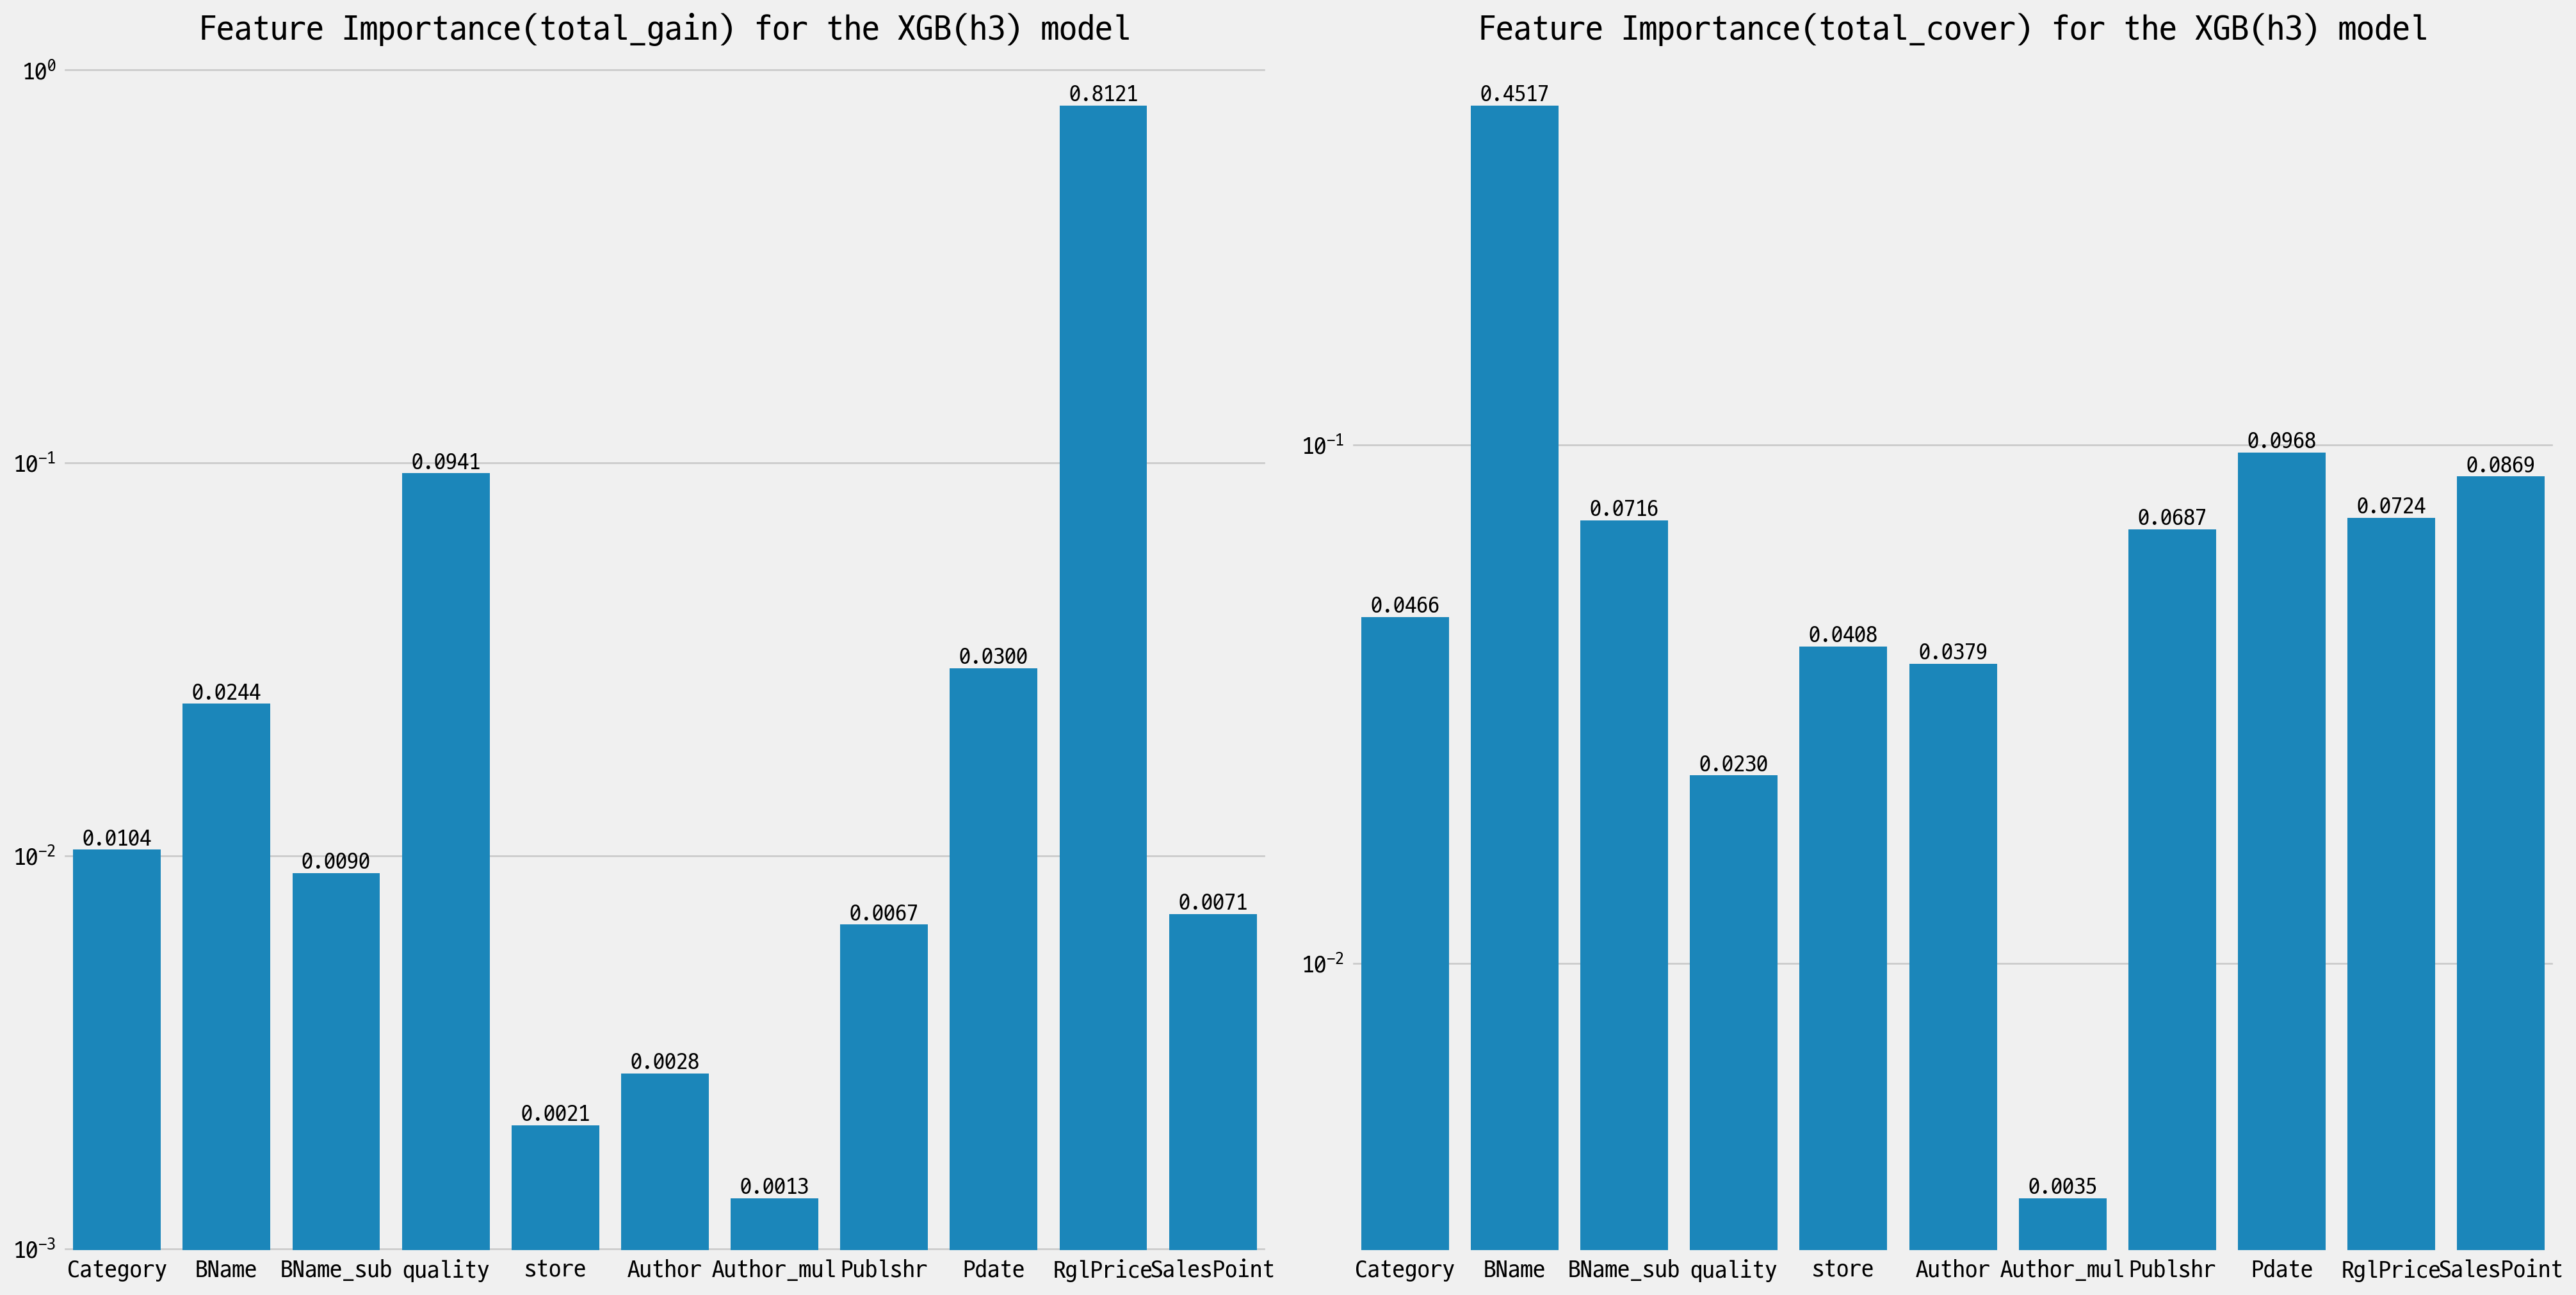

In [45]:
plot_xgb_fi('base','h3');

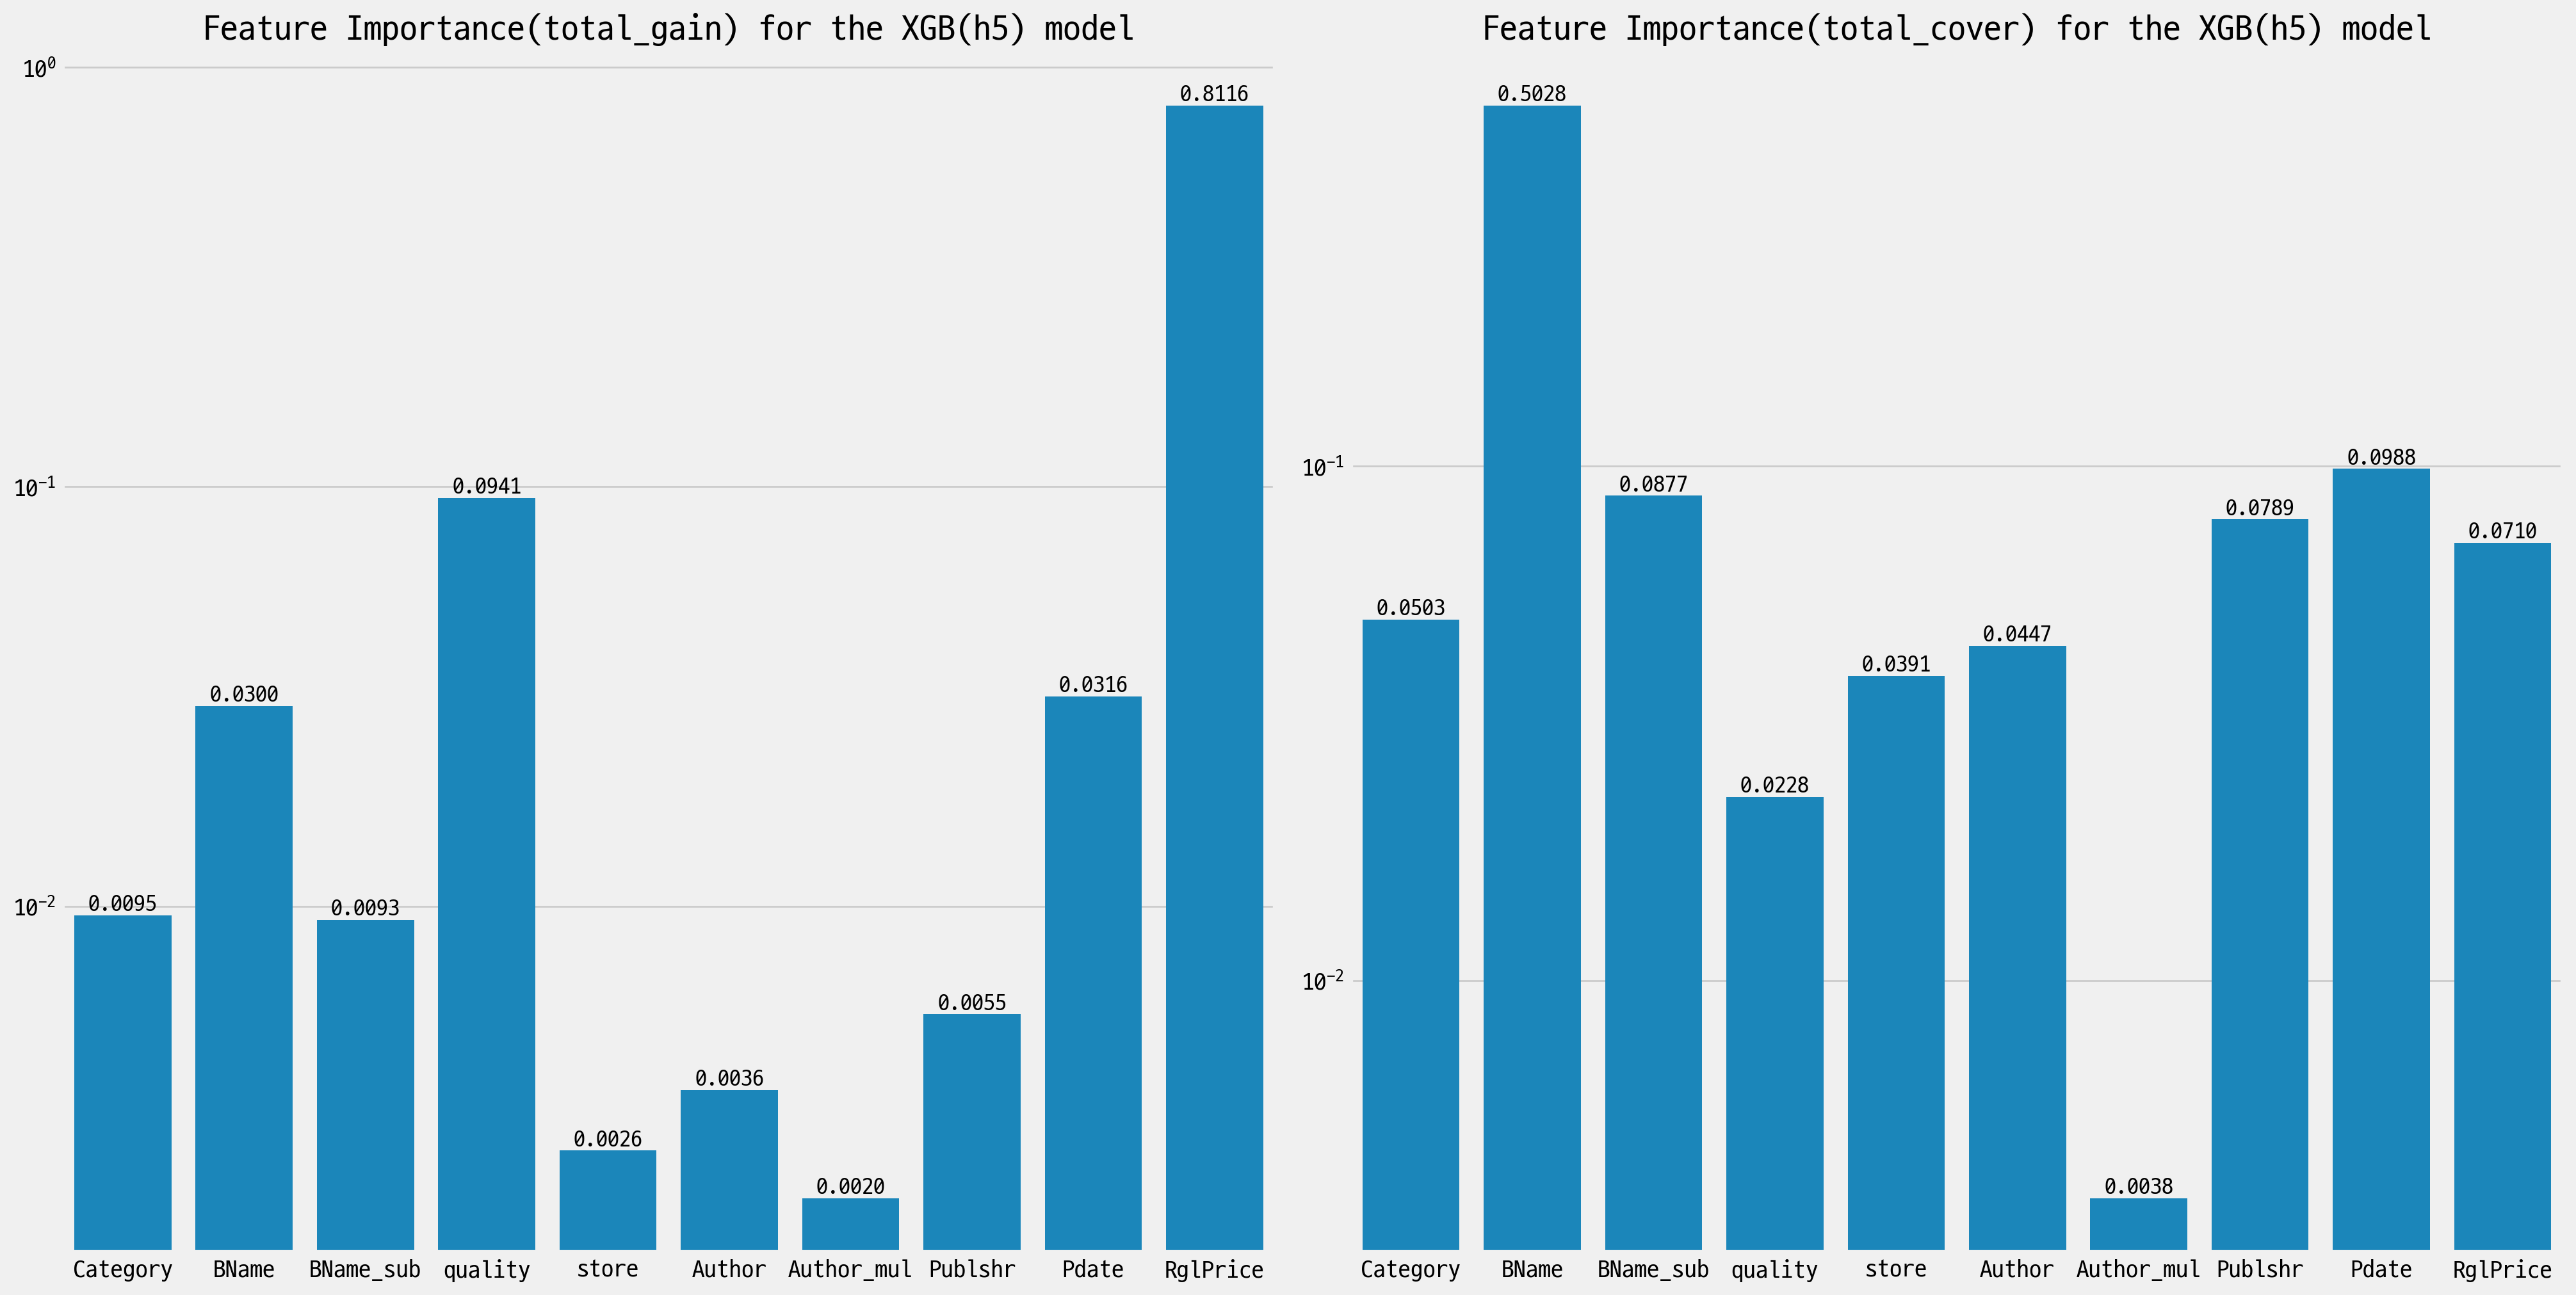

In [46]:
plot_xgb_fi('crop1','h5');

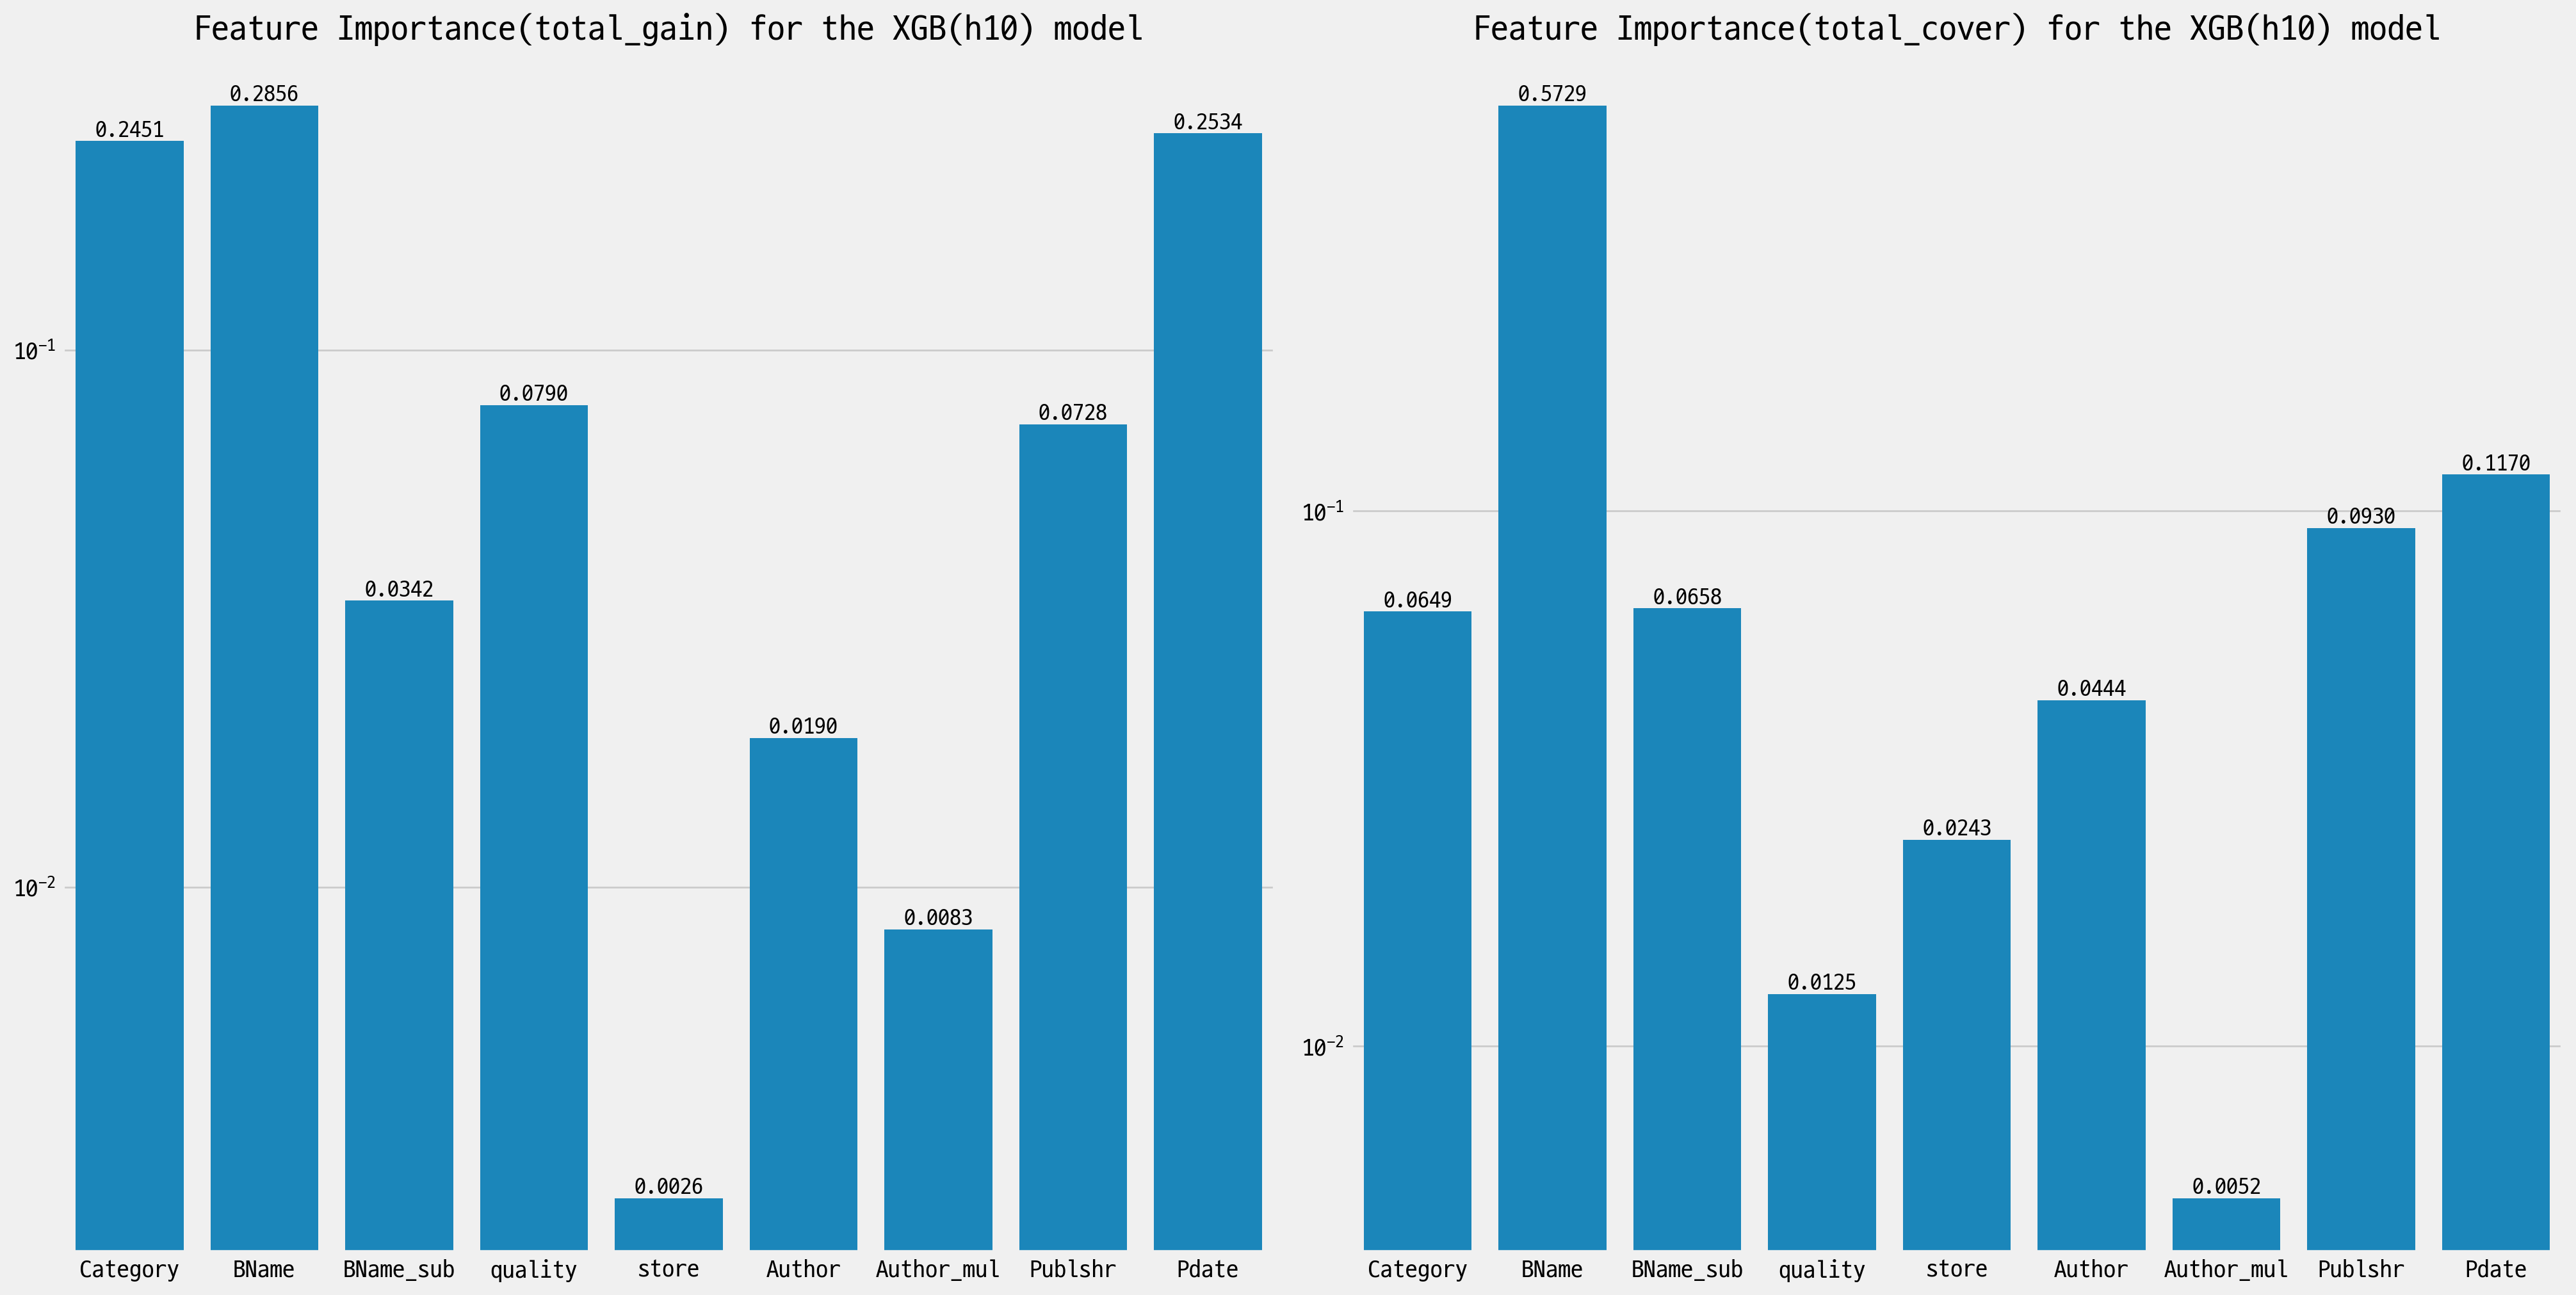

In [47]:
plot_xgb_fi('crop2','h10');

### plot distribution of prediction

In [48]:
data_dict.keys()
pred_dict['base'].keys()

dict_keys(['test1', 'test2', 'test3'])

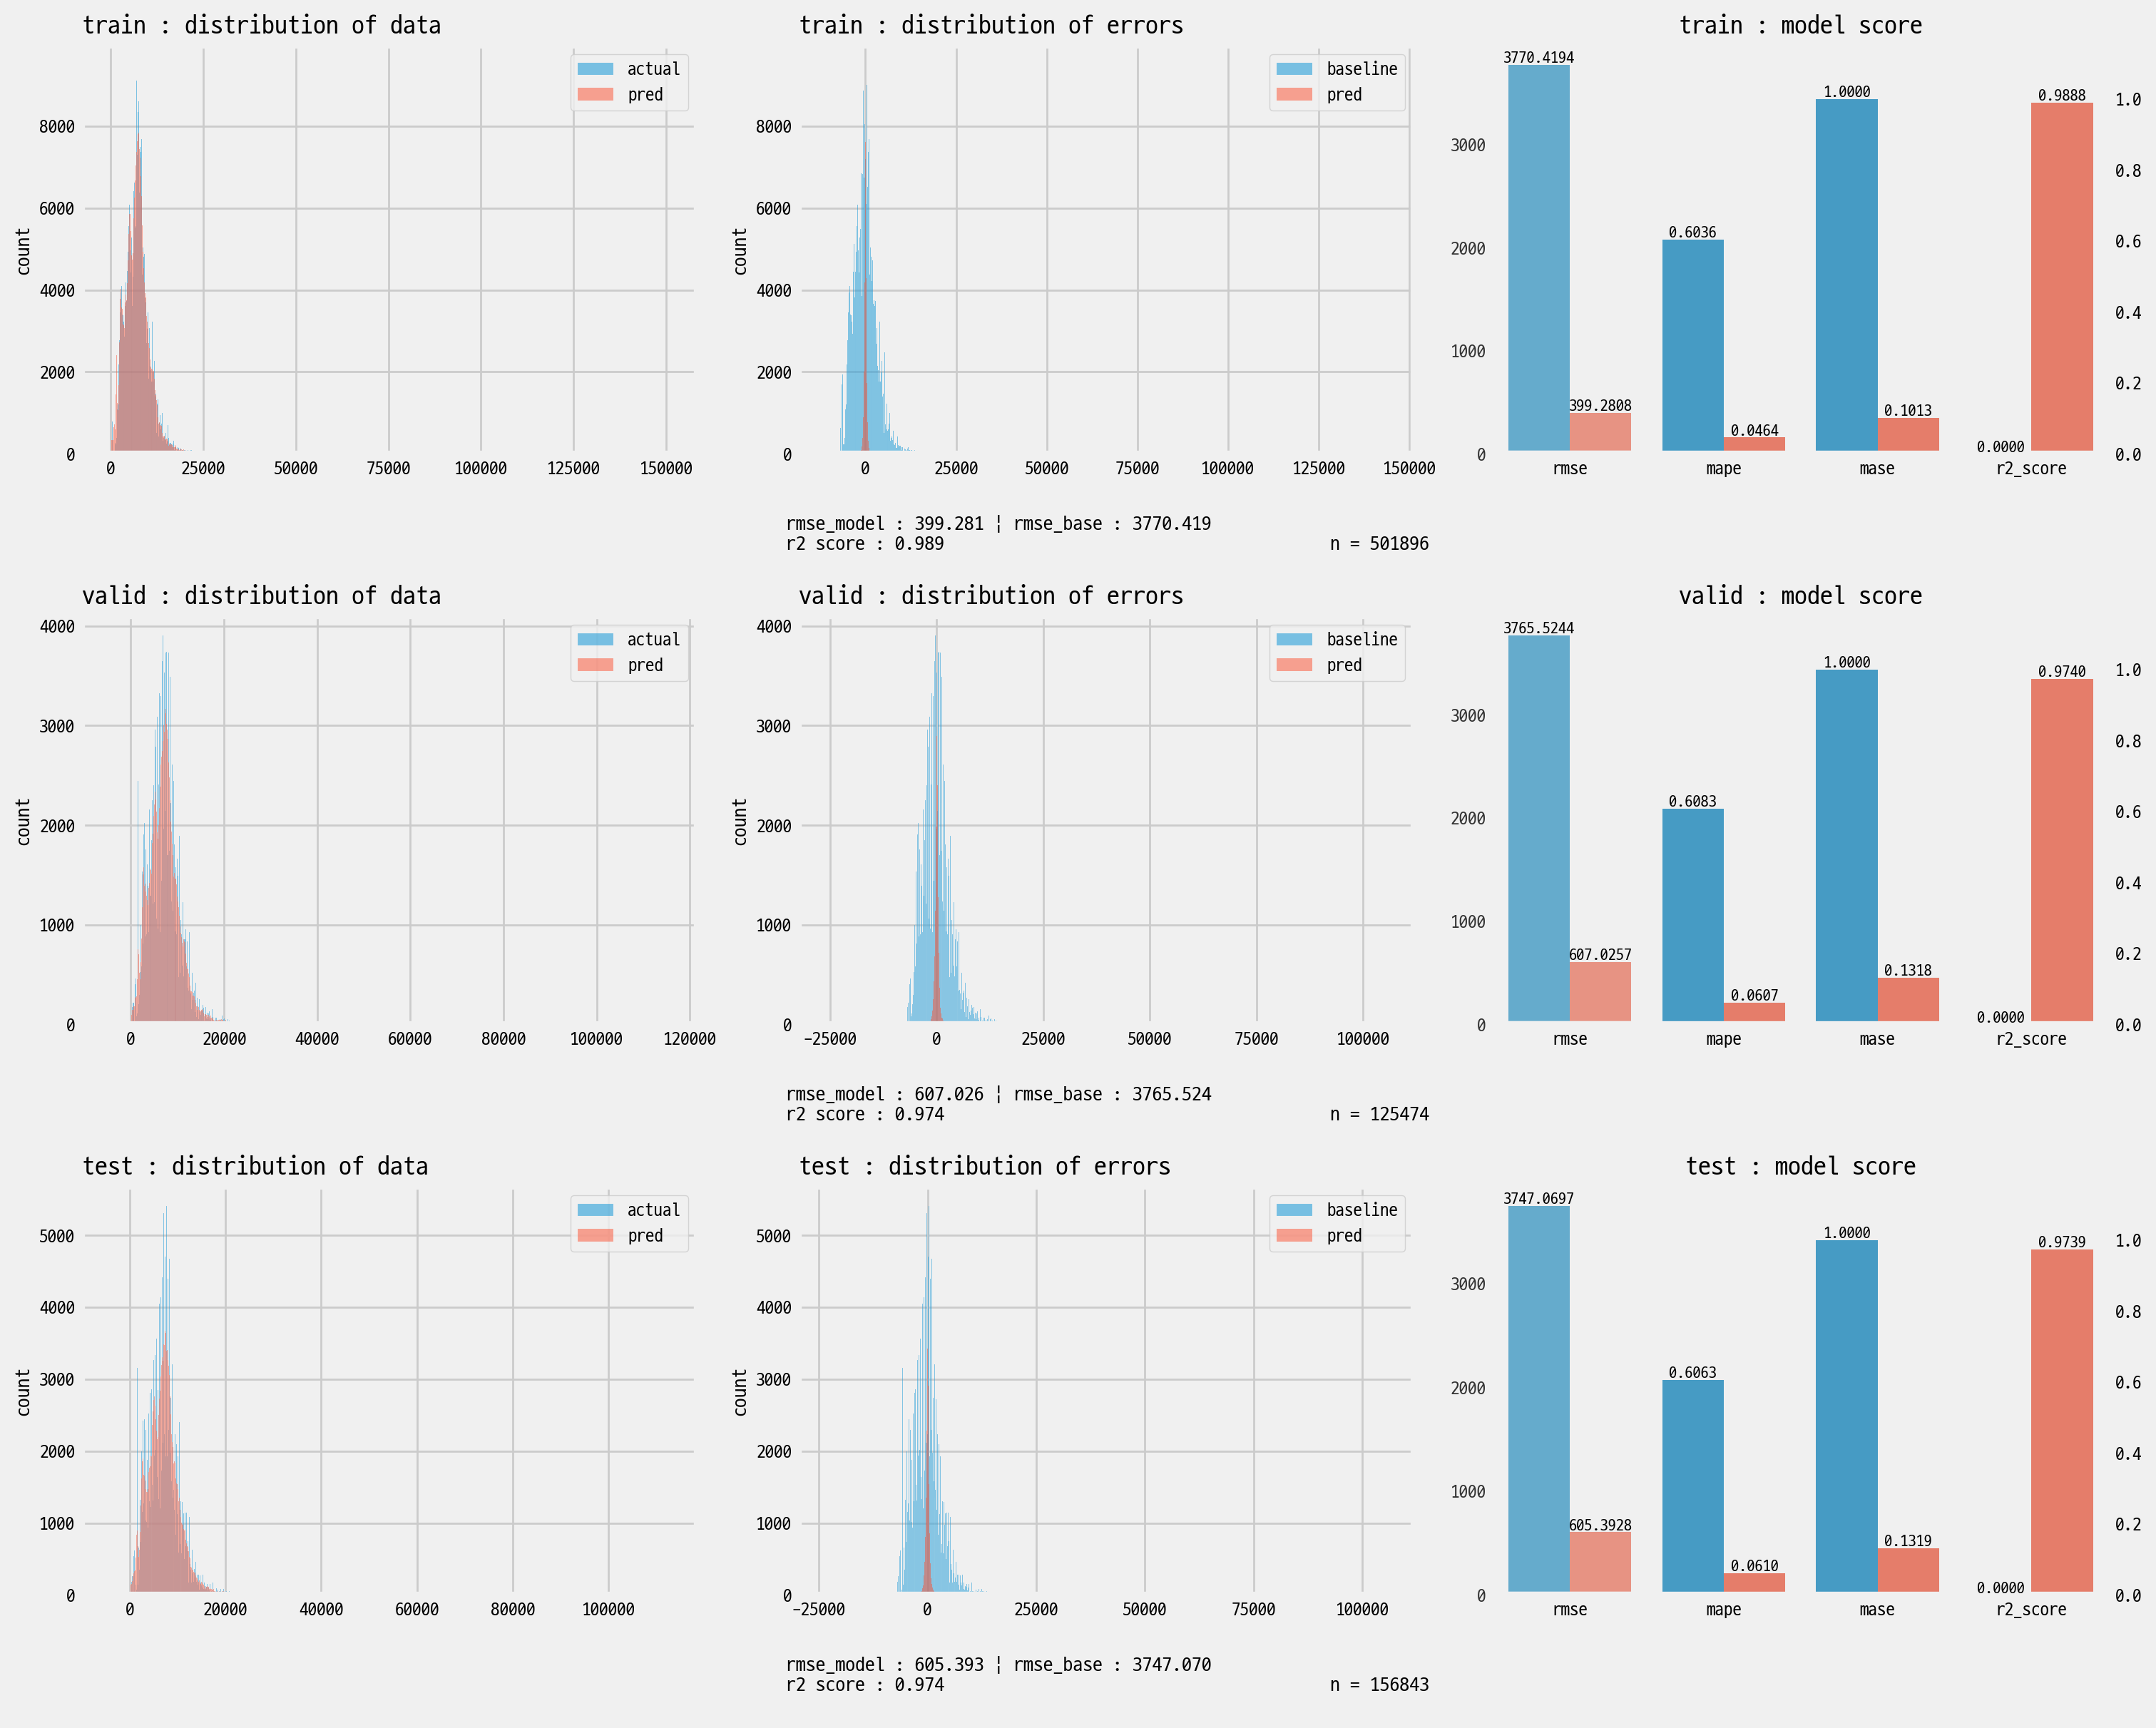

In [49]:
re_abbv = {
    'trn':'train',
    'vld':'valid',
    'tst':'test'
}

expt, param = 'base','h3'

data_temp = {
    re_abbv[key]:val
    for key, val in data_dict[expt]['test1'].items()
}
pred_temp = {
    re_abbv[key]:val
    for key, val in pred_dict[expt]['test1'][param].items()
}

plot_reg_score(data_temp,pred_temp);

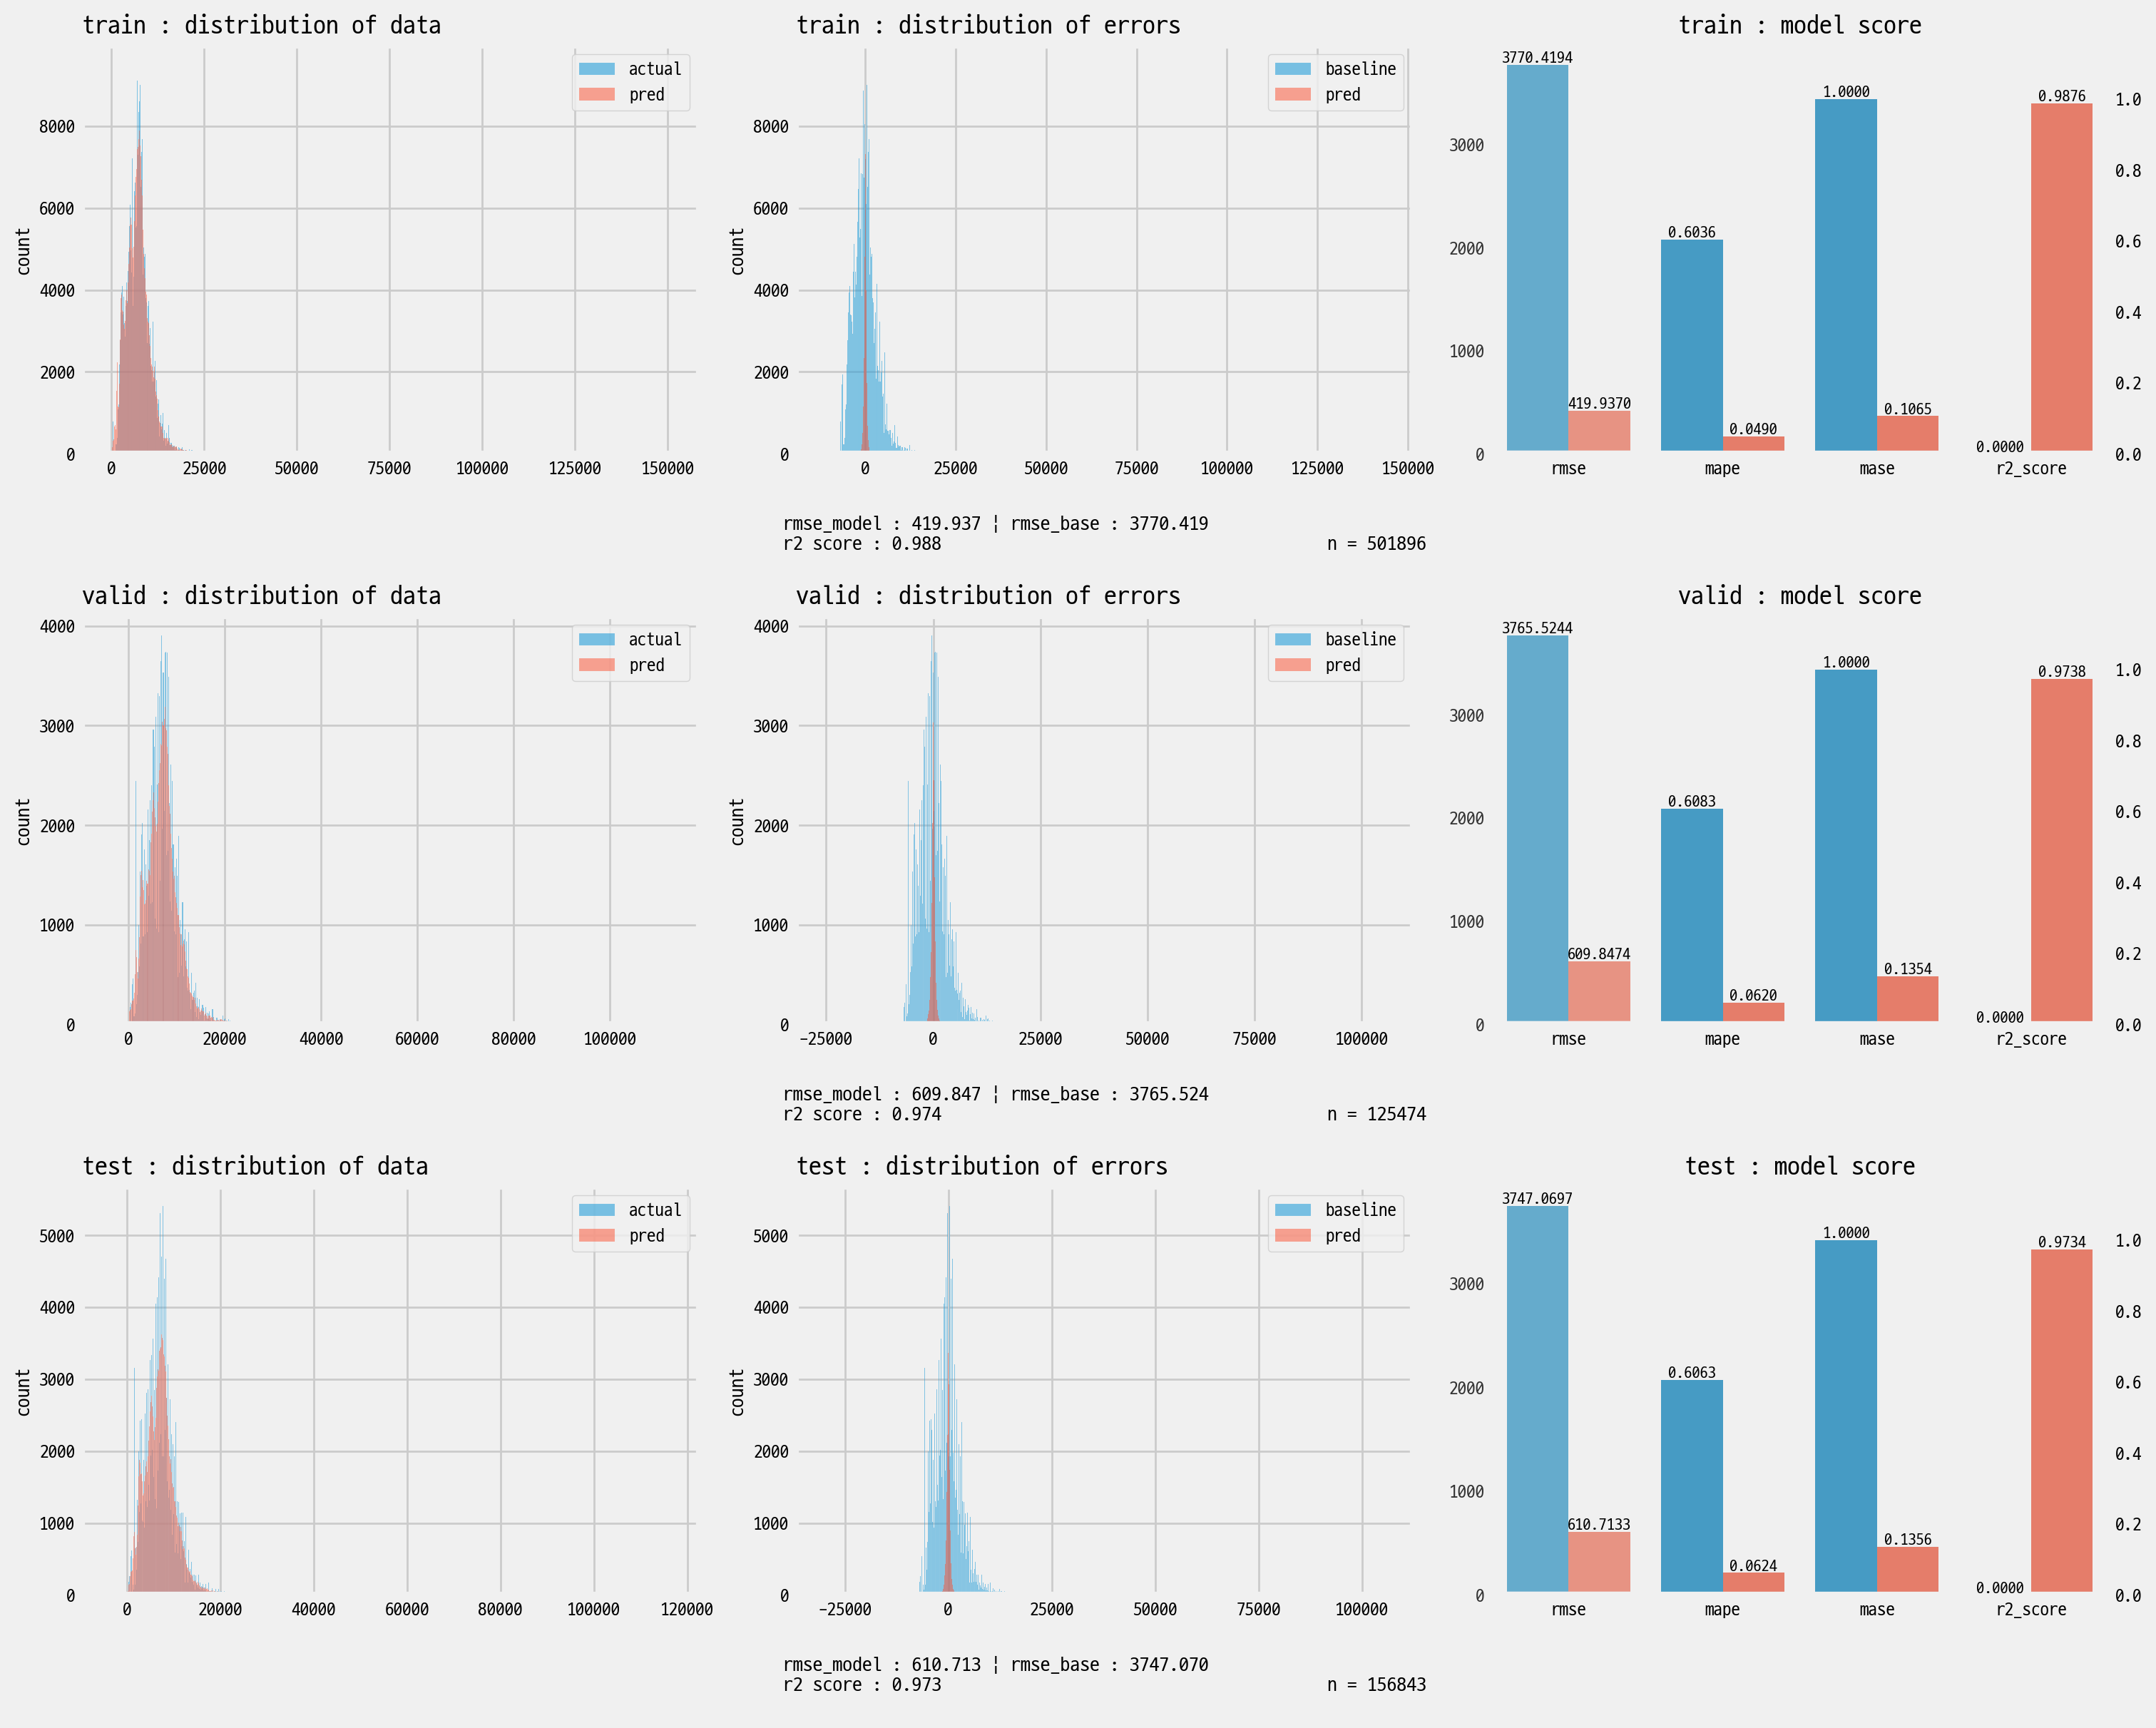

In [50]:
expt, param = 'crop1','h5'

data_temp = {
    re_abbv[key]:val
    for key, val in data_dict[expt]['test1'].items()
}
pred_temp = {
    re_abbv[key]:val
    for key, val in pred_dict[expt]['test1'][param].items()
}

plot_reg_score(data_temp,pred_temp);

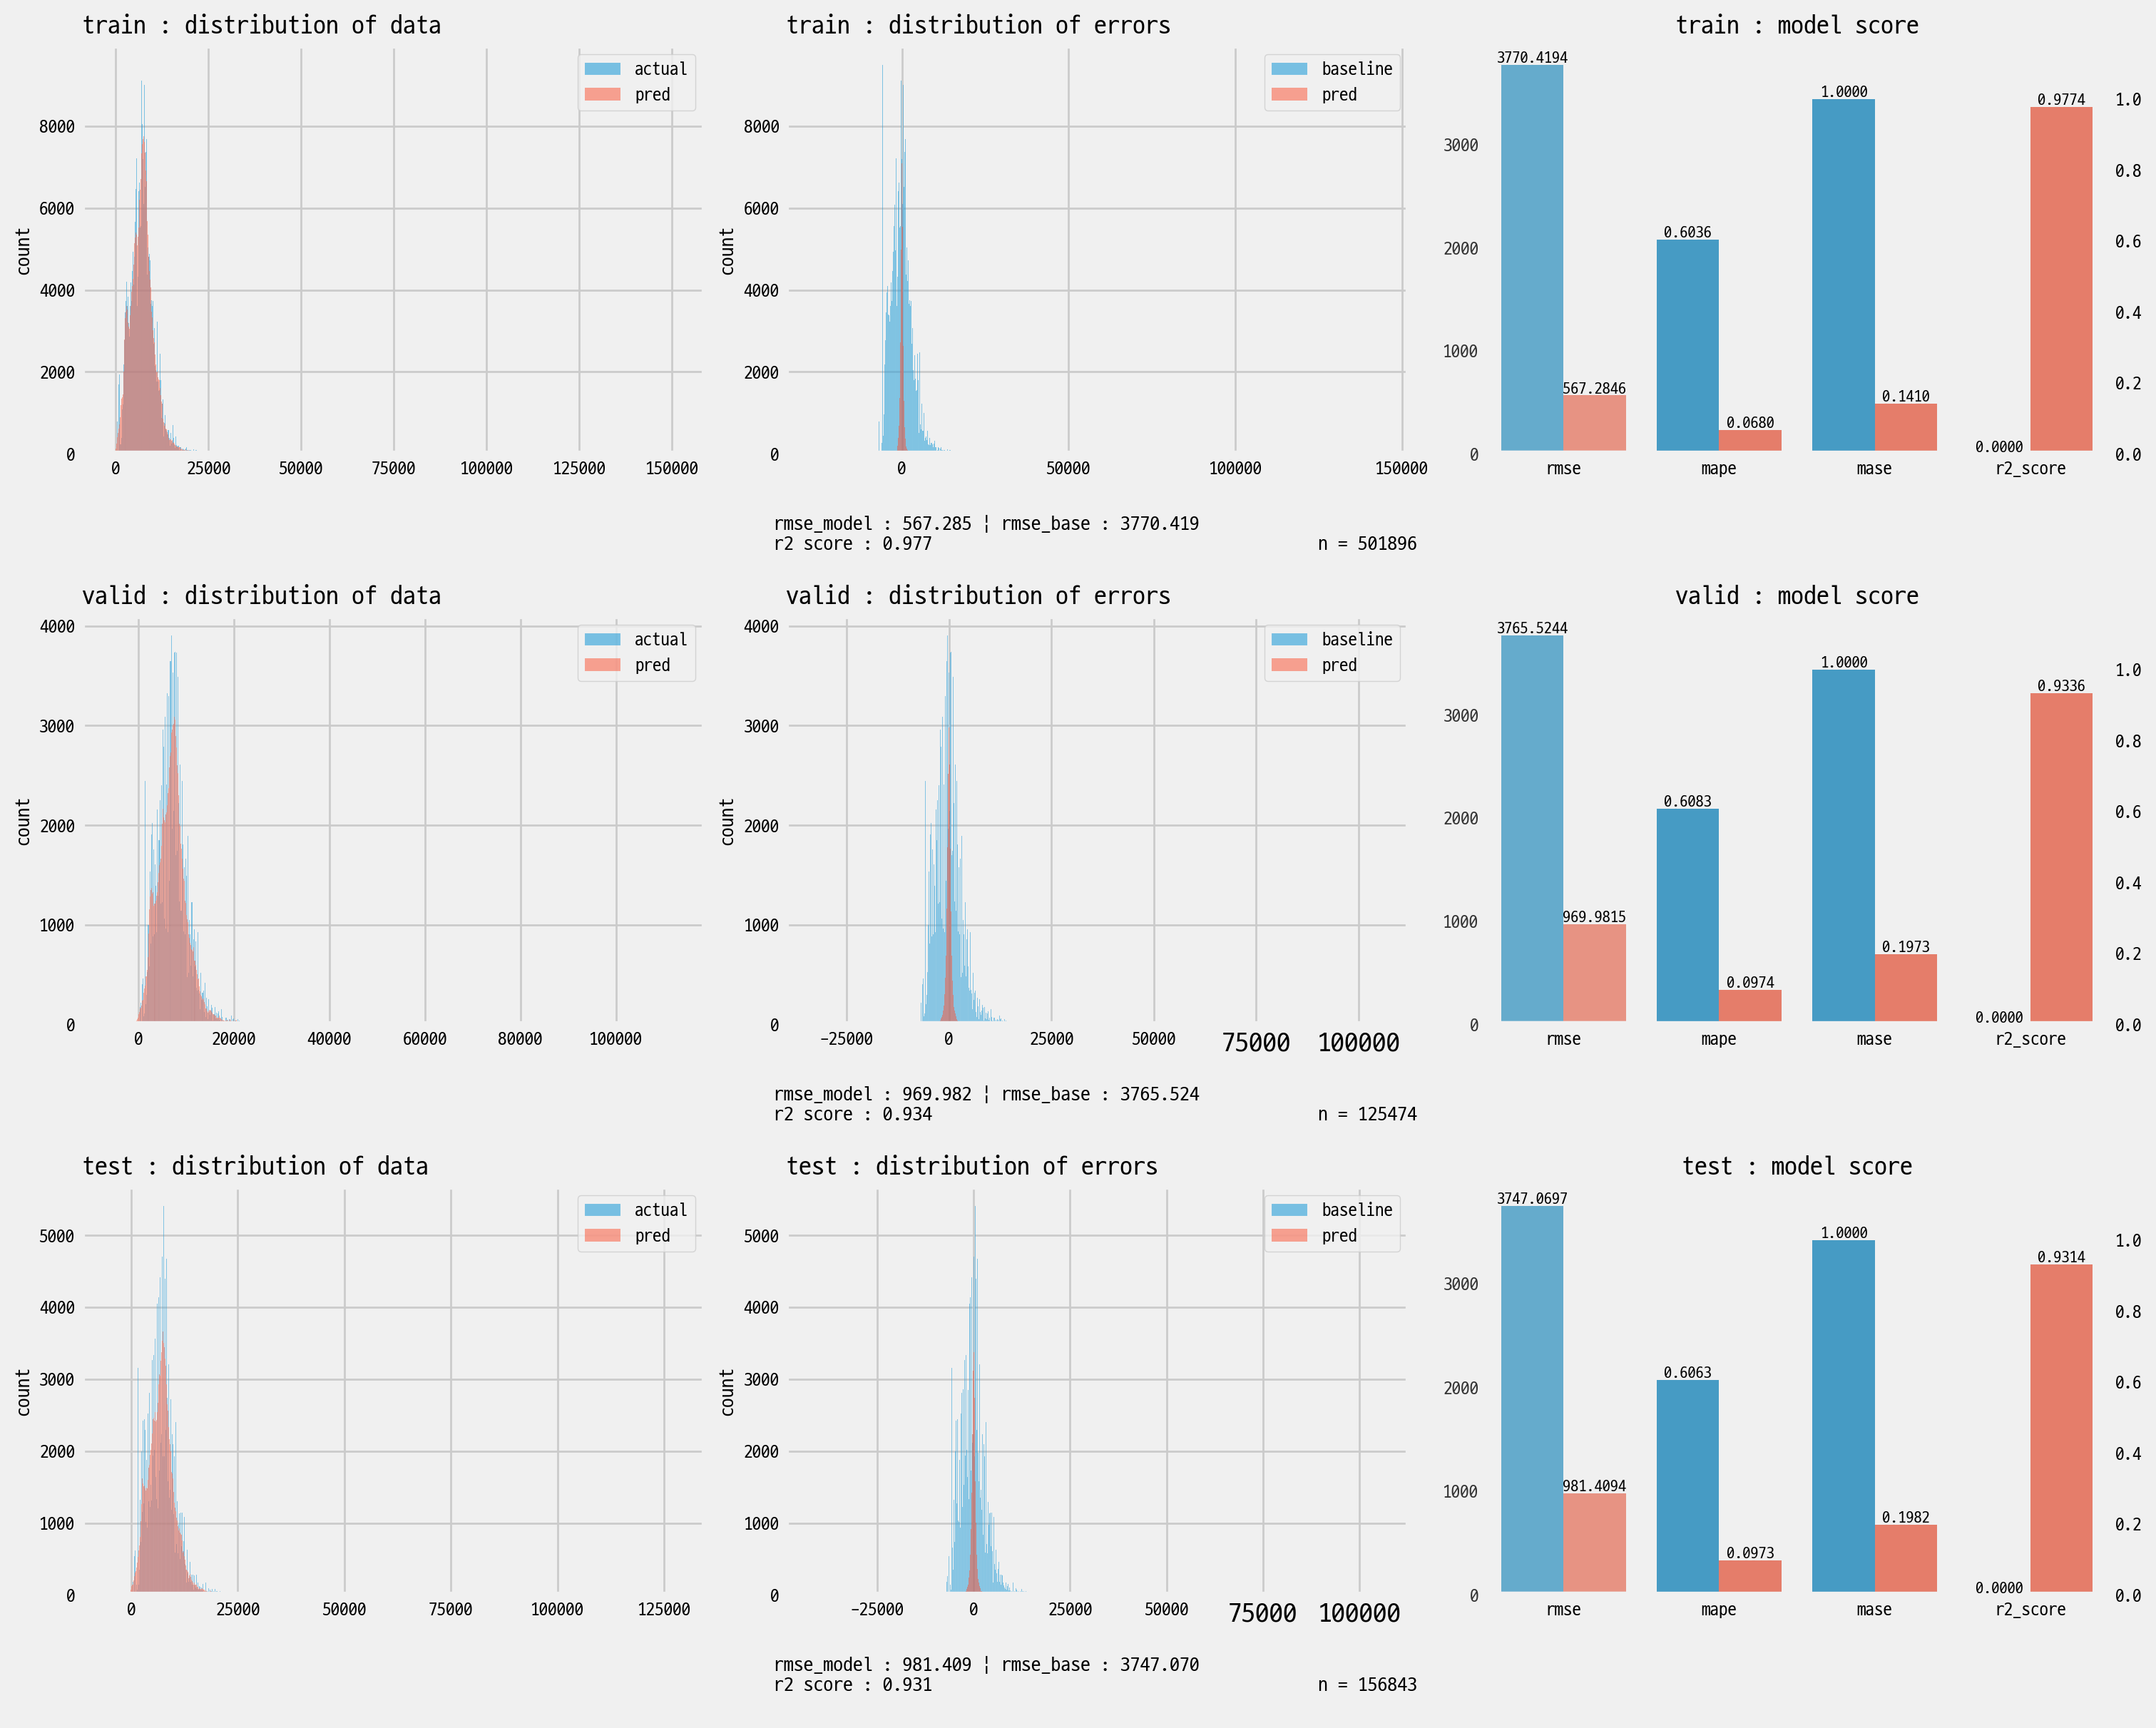

In [51]:
expt, param = 'crop2','h10'

data_temp = {
    re_abbv[key]:val
    for key, val in data_dict[expt]['test1'].items()
}
pred_temp = {
    re_abbv[key]:val
    for key, val in pred_dict[expt]['test1'][param].items()
}

plot_reg_score(data_temp,pred_temp);

In [57]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(data_dict['crop2']['test1']['trn']['X'],data_dict['crop2']['test1']['trn']['y'])

DecisionTreeRegressor()

In [60]:
pred_base = {
    'train' : model.predict(data_dict['crop2']['test3']['trn']['X']),
    'valid' : model.predict(data_dict['crop2']['test3']['vld']['X']),
    'test' : model.predict(data_dict['crop2']['test3']['tst']['X']),
}

In [62]:
make_reg_score_entire(data_temp,pred_base,print_rslt=True)

train
r2 score : 0.99955
rmse_model : 80.04733 / rmse_base : 3770.41936	 mape_model : 0.00150 / mape_base : 0.60355	
------------------------------------------------------------------------------------------------------------------------------------------------------
valid
r2 score : 0.87276
rmse_model : 1343.16755 / rmse_base : 3765.52438	 mape_model : 0.08146 / mape_base : 0.60827	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.03936
rmse_model : 4822.36668 / rmse_base : 4920.16752	 mape_model : 0.43589 / mape_base : 1.06020	
------------------------------------------------------------------------------------------------------------------------------------------------------


{'train': {'rmse': [80.04732559719618, 3770.419357315864],
  'mape': [0.0015037600683137267, 0.603550938603315],
  'mase': [0.0038783942568483497, 1.0],
  'r2_score': [0.9995492722051537, 0.0]},
 'valid': {'rmse': [1343.1675472105762, 3765.52437655531],
  'mape': [0.08145533476419074, 0.6082663487145532],
  'mase': [0.18669556766642964, 1.0],
  'r2_score': [0.8727641623232235, 0.0]},
 'test': {'rmse': [4822.366679169844, 4920.167517285162],
  'mape': [0.43589352728923125, 1.0601972668077895],
  'mase': [0.7064295047764967, 1.0],
  'r2_score': [0.039359967978804034, 0.0]}}

train
r2 score : 0.97736
rmse_model : 567.28463 / rmse_base : 3770.41936	 mape_model : 0.06795 / mape_base : 0.60355	
------------------------------------------------------------------------------------------------------------------------------------------------------
valid
r2 score : 0.93364
rmse_model : 969.98151 / rmse_base : 3765.52438	 mape_model : 0.09742 / mape_base : 0.60827	
------------------------------------------------------------------------------------------------------------------------------------------------------
test
r2 score : 0.51455
rmse_model : 3428.10233 / rmse_base : 4920.16752	 mape_model : 0.42367 / mape_base : 1.06020	
------------------------------------------------------------------------------------------------------------------------------------------------------


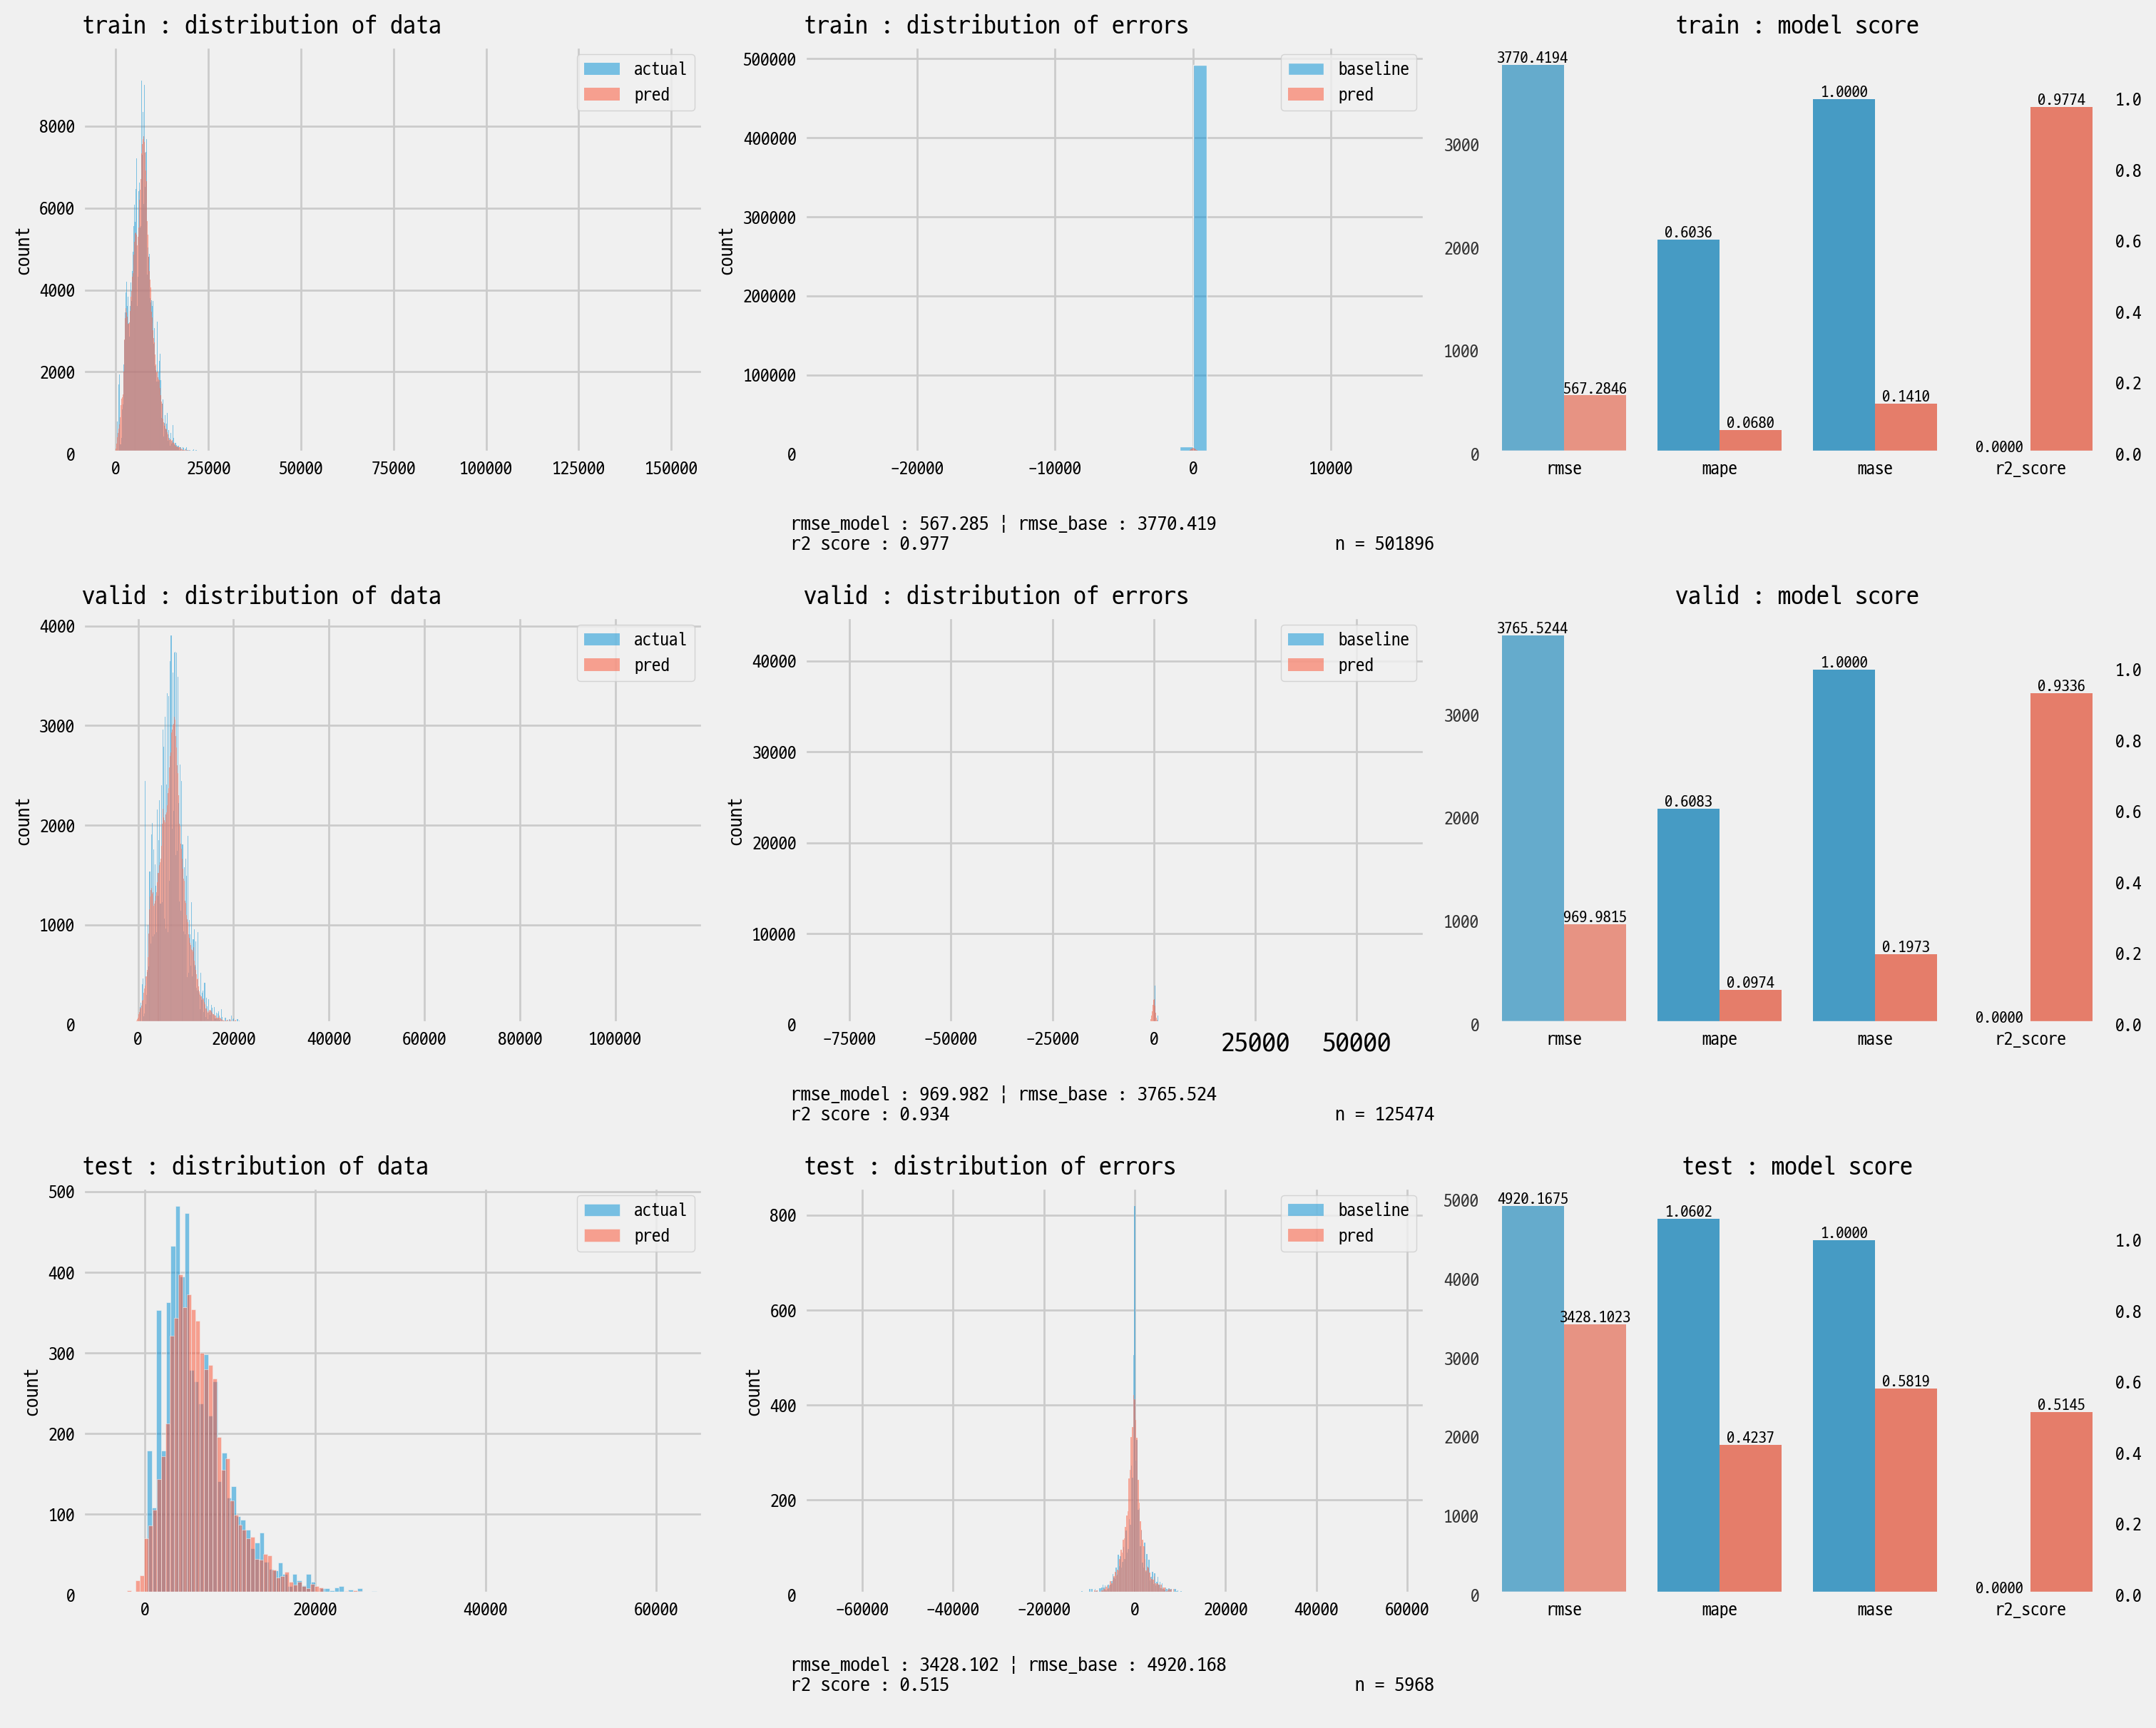

In [61]:
expt, param = 'crop2','h10'

data_temp = {
    re_abbv[key]:val
    for key, val in data_dict[expt]['test3'].items()
}
pred_temp = {
    re_abbv[key]:val
    for key, val in pred_dict[expt]['test3'][param].items()
}

plot_reg_score(data_temp,pred_temp,pred_base);

### 저번 학습 결과 이용

In [5]:
base_score1 = '''
h0 | rmse : 791.4488859443696 ,mape :  0.08122519675552106 ,r2 :  0.9553869211457245
h1 | rmse : 624.7671236439437 ,mape :  0.06397802597064346 ,r2 :  0.9721994884078433
h2 | rmse : 610.1394741853122 ,mape :  0.06264422570999852 ,r2 :  0.9734860337800322
h3 | rmse : 605.392781947453 ,mape :  0.06100690931146923 ,r2 :  0.9738969696142032
h4 | rmse : 625.1339995887683 ,mape :  0.0630024481117587 ,r2 :  0.9721668287713151
h5 | rmse : 612.008639862158 ,mape :  0.06161841215024934 ,r2 :  0.9733233335783734
h6 | rmse : 612.2191067254565 ,mape :  0.063285708584617 ,r2 :  0.9733049824658285
h7 | rmse : 611.0387447728924 ,mape :  0.06167623884598391 ,r2 :  0.9734078195290736
h8 | rmse : 621.2584567379221 ,mape :  0.06484077834476312 ,r2 :  0.9725108647056184
h9 | rmse : 646.5400066568483 ,mape :  0.06398389765383244 ,r2 :  0.9702280515418517
h10 | rmse : 629.7749280254653 ,mape :  0.06321842298513085 ,r2 :  0.9717520337525706
h11 | rmse : 633.1402394923974 ,mape :  0.06436024037680939 ,r2 :  0.9714493313303474
h12 | rmse : 631.1859073347507 ,mape :  0.06335007248857319 ,r2 :  0.9716253156402087
h13 | rmse : 639.1720406436829 ,mape :  0.06306160781348834 ,r2 :  0.9709027469880859
h14 | rmse : 605.392781947453 ,mape :  0.06100690931146923 ,r2 :  0.9738969696142032
h15 | rmse : 612.008639862158 ,mape :  0.06161841215024934 ,r2 :  0.9733233335783734
h16 | rmse : 633.1992896057047 ,mape :  0.06479084034584318 ,r2 :  0.9714440054997214
'''

def score_str_read(score_str):
    score_list = score_str.strip().split('\n')
    score = {
        sent.split(' | ')[0] : sent.split(' | ')[-1]
        for sent in score_list
    }
    for key,sent in score.items():
        score[key] = {
            val.split(' : ')[0] : float(val.split(' : ')[1])
            for val in sent.strip().split(' ,')
        }
    return score

In [6]:
base_score2='''
h0 | rmse : 1465.4972964477354 ,mape :  0.1380264800059021 ,r2 :  0.9118264410027117
h1 | rmse : 1514.0488079119218 ,mape :  0.14643324502952235 ,r2 :  0.9058873334226022
h2 | rmse : 1541.1603445777093 ,mape :  0.15590146148679643 ,r2 :  0.9024866718975307
h3 | rmse : 1485.5413436652163 ,mape :  0.1507229356771503 ,r2 :  0.9093979939397914
h4 | rmse : 1596.5786091926311 ,mape :  0.15155072716152032 ,r2 :  0.8953476607681907
h5 | rmse : 1524.8268835774506 ,mape :  0.14971187669214533 ,r2 :  0.9045426424449303
h6 | rmse : 1533.2101326385123 ,mape :  0.15333085741077548 ,r2 :  0.9034901392213496
h7 | rmse : 1555.2044400921673 ,mape :  0.14961858575778178 ,r2 :  0.9007013594966813
h8 | rmse : 1585.7663176057385 ,mape :  0.1609279357205842 ,r2 :  0.8967603067123805
h9 | rmse : 1709.5816375517427 ,mape :  0.16897856823133695 ,r2 :  0.8800091812932793
h10 | rmse : 1617.270722867392 ,mape :  0.1632617801528532 ,r2 :  0.8926174341526679
h11 | rmse : 1668.659082870821 ,mape :  0.16880299108847074 ,r2 :  0.8856849103828757
h12 | rmse : 1557.8436089694346 ,mape :  0.16119981843086978 ,r2 :  0.9003640556199561
h13 | rmse : 1652.8600899787862 ,mape :  0.16236871864816224 ,r2 :  0.8878393508357063
h14 | rmse : 1485.5413436652163 ,mape :  0.1507229356771503 ,r2 :  0.9093979939397914
h15 | rmse : 1524.8268835774506 ,mape :  0.14971187669214533 ,r2 :  0.9045426424449303
h16 | rmse : 1682.6570711143604 ,mape :  0.1693360651130569 ,r2 :  0.8837589411192263
'''
base_score3 ='''
h0 | rmse : 1461.5884173411168 ,mape :  0.13293986677473835 ,r2 :  0.9117549392428868
h1 | rmse : 1461.724476010208 ,mape :  0.14177207884485574 ,r2 :  0.9117385090848226
h2 | rmse : 1463.046444319457 ,mape :  0.15186365705355762 ,r2 :  0.9115787913576892
h3 | rmse : 1477.9569909375282 ,mape :  0.14469155401626332 ,r2 :  0.9097673289835202
h4 | rmse : 1577.7550535159467 ,mape :  0.1473951802801411 ,r2 :  0.897170107728075
h5 | rmse : 1469.0303354255152 ,mape :  0.1452420265086275 ,r2 :  0.9108540229717362
h6 | rmse : 1474.0908866387 ,mape :  0.14800434883269734 ,r2 :  0.9102387806595139
h7 | rmse : 1499.1521766645676 ,mape :  0.14275694869781475 ,r2 :  0.907160742087328
h8 | rmse : 1501.2750188623734 ,mape :  0.15368738801786172 ,r2 :  0.9068976298629409
h9 | rmse : 1781.3750183893246 ,mape :  0.16448597835744097 ,r2 :  0.8689156224429752
h10 | rmse : 1606.710153805525 ,mape :  0.1594044817579703 ,r2 :  0.8933611881518188
h11 | rmse : 1659.7814941435022 ,mape :  0.1647363680999849 ,r2 :  0.8862000536766941
h12 | rmse : 1607.7526590409777 ,mape :  0.15510349122000897 ,r2 :  0.8932227592187447
h13 | rmse : 1665.975985691722 ,mape :  0.1588399788785707 ,r2 :  0.8853490401517111
h14 | rmse : 1477.9569909375282 ,mape :  0.14469155401626332 ,r2 :  0.9097673289835202
h15 | rmse : 1469.0303354255152 ,mape :  0.1452420265086275 ,r2 :  0.9108540229717362
h16 | rmse : 1646.5091590307663 ,mape :  0.16482566290075024 ,r2 :  0.8880127647555597'''

crop1_score1 = '''
h0 | rmse : 811.290202387322 ,mape :  0.08258996025167503 ,r2 :  0.9531220173262255
h1 | rmse : 627.1682668812718 ,mape :  0.06514195400083164 ,r2 :  0.9719853885216627
h2 | rmse : 617.0868162426957 ,mape :  0.0644508990033339 ,r2 :  0.9728787946010812
h3 | rmse : 622.1652395930803 ,mape :  0.062145094416463174 ,r2 :  0.972430560388837
h4 | rmse : 631.4885844297982 ,mape :  0.06511409721356617 ,r2 :  0.9715980956843903
h5 | rmse : 610.7133064824715 ,mape :  0.062428159043813776 ,r2 :  0.9734361378942877
h6 | rmse : 622.6130955920544 ,mape :  0.06531701850671476 ,r2 :  0.9723908552363134
h7 | rmse : 611.444025201597 ,mape :  0.06265805791890933 ,r2 :  0.9733725325215253
h8 | rmse : 640.0128344645982 ,mape :  0.06575477763750524 ,r2 :  0.9708261451344714
h9 | rmse : 632.7149420345761 ,mape :  0.06554149148857233 ,r2 :  0.9714876749636058
h10 | rmse : 651.008235985234 ,mape :  0.06338665255390265 ,r2 :  0.9698151225076573
h11 | rmse : 645.8208734794665 ,mape :  0.06778141648331175 ,r2 :  0.9702942441632572
h12 | rmse : 651.3753329204034 ,mape :  0.06427429624090453 ,r2 :  0.9697810710177628
h13 | rmse : 626.9523798455926 ,mape :  0.0638069063254285 ,r2 :  0.9720046718649439
h14 | rmse : 622.1652395930803 ,mape :  0.062145094416463174 ,r2 :  0.972430560388837
h15 | rmse : 610.7133064824715 ,mape :  0.062428159043813776 ,r2 :  0.9734361378942877
h16 | rmse : 630.6580240941195 ,mape :  0.06626020854662697 ,r2 :  0.9716727573103187'''

crop1_score2='''
h0 | rmse : 1561.9699414388242 ,mape :  0.14030659458852715 ,r2 :  0.8998355359136898
h1 | rmse : 1449.7483402211071 ,mape :  0.14850279353387646 ,r2 :  0.9137113711370078
h2 | rmse : 1478.9220298641876 ,mape :  0.1582477617740397 ,r2 :  0.9102036086481857
h3 | rmse : 1590.4206873882417 ,mape :  0.15347739699656518 ,r2 :  0.8961533813636471
h4 | rmse : 1567.2867098560625 ,mape :  0.15927983058351333 ,r2 :  0.8991524784270437
h5 | rmse : 1452.57895793704 ,mape :  0.1504349992387474 ,r2 :  0.9133740869855446
h6 | rmse : 1584.601200977112 ,mape :  0.15837284064459 ,r2 :  0.8969119584315904
h7 | rmse : 1457.7771358683694 ,mape :  0.15039958010314988 ,r2 :  0.912752981165674
h8 | rmse : 1689.797970762059 ,mape :  0.16149706532349262 ,r2 :  0.8827702345349371
h9 | rmse : 1562.7594641935475 ,mape :  0.17832650018321974 ,r2 :  0.8997342508528496
h10 | rmse : 1751.7206979869015 ,mape :  0.16205459015837623 ,r2 :  0.8740210307360502
h11 | rmse : 1668.3608729393573 ,mape :  0.17743789171303717 ,r2 :  0.8857257657610028
h12 | rmse : 1774.6644306146036 ,mape :  0.15994926804869397 ,r2 :  0.8706993174620846
h13 | rmse : 1571.7436018202493 ,mape :  0.15854481468815307 ,r2 :  0.8985781028779477
h14 | rmse : 1590.4206873882417 ,mape :  0.15347739699656518 ,r2 :  0.8961533813636471
h15 | rmse : 1452.57895793704 ,mape :  0.1504349992387474 ,r2 :  0.9133740869855446
h16 | rmse : 1574.0658009582348 ,mape :  0.17518445807197144 ,r2 :  0.8982781864925284'''

crop1_score3='''
h0 | rmse : 1569.4088893441246 ,mape :  0.13520766902505071 ,r2 :  0.8982551496327649
h1 | rmse : 1438.3656376179645 ,mape :  0.14309501075692416 ,r2 :  0.9145368650354149
h2 | rmse : 1482.9574737935236 ,mape :  0.15337315951943267 ,r2 :  0.909155714128186
h3 | rmse : 1588.1605540546198 ,mape :  0.14704481206536502 ,r2 :  0.8958092819391408
h4 | rmse : 1559.1431548444714 ,mape :  0.1535911803521382 ,r2 :  0.8995818523940021
h5 | rmse : 1440.4045101749557 ,mape :  0.14447651431093317 ,r2 :  0.9142944066035874
h6 | rmse : 1475.1466811920773 ,mape :  0.15186129644087126 ,r2 :  0.9101101544724906
h7 | rmse : 1445.237036418425 ,mape :  0.14406189906606973 ,r2 :  0.9137183610556849
h8 | rmse : 1598.4347019707561 ,mape :  0.15289398696738565 ,r2 :  0.8944568577176257
h9 | rmse : 1631.2766835014104 ,mape :  0.17081529034780008 ,r2 :  0.8900752520662121
h10 | rmse : 1746.735938044122 ,mape :  0.15631211059727007 ,r2 :  0.8739639649147308
h11 | rmse : 1607.9471908898017 ,mape :  0.1702768526521167 ,r2 :  0.8931969183898277
h12 | rmse : 1718.4535104440638 ,mape :  0.15414224878555452 ,r2 :  0.8780123693166673
h13 | rmse : 1549.0809095040722 ,mape :  0.15405420008874132 ,r2 :  0.9008738075567653
h14 | rmse : 1588.1605540546198 ,mape :  0.14704481206536502 ,r2 :  0.8958092819391408
h15 | rmse : 1440.4045101749557 ,mape :  0.14447651431093317 ,r2 :  0.9142944066035874
h16 | rmse : 1568.9100799130722 ,mape :  0.16898197241165663 ,r2 :  0.8983198150313864
'''

crop2_score2='''
h0 | rmse : 3359.571915663408 ,mape :  0.41231842081063963 ,r2 :  0.536621145231975
h1 | rmse : 3169.7035639891596 ,mape :  0.3980882032379422 ,r2 :  0.5875174087397133
h2 | rmse : 3272.8169254940826 ,mape :  0.4054247805187143 ,r2 :  0.5602440213517252
h3 | rmse : 3285.071207098151 ,mape :  0.40819155341770286 ,r2 :  0.55694473365242
h4 | rmse : 3175.9001451085255 ,mape :  0.39620875903930086 ,r2 :  0.5859030746663066
h5 | rmse : 3162.368273936021 ,mape :  0.3979960913916121 ,r2 :  0.5894243242554192
h6 | rmse : 3172.7670522035846 ,mape :  0.40062749200990755 ,r2 :  0.5867197024701482
h7 | rmse : 3203.4986811406307 ,mape :  0.398721677408037 ,r2 :  0.5786748086488542
h8 | rmse : 3391.6038475666064 ,mape :  0.43446558370752264 ,r2 :  0.5277428235813735
h9 | rmse : 3313.579114069289 ,mape :  0.4306526958999949 ,r2 :  0.5492216849212354
h10 | rmse : 3414.442179964779 ,mape :  0.4370845706102369 ,r2 :  0.5213612526766207
h11 | rmse : 3372.8946530323306 ,mape :  0.4345545759649852 ,r2 :  0.5329387025143251
h12 | rmse : 3368.3006297426327 ,mape :  0.4338181164087716 ,r2 :  0.5342101500031731
h13 | rmse : 3319.916979427768 ,mape :  0.4279898530937035 ,r2 :  0.5474956331645289
h14 | rmse : 3285.071207098151 ,mape :  0.40819155341770286 ,r2 :  0.55694473365242
h15 | rmse : 3162.368273936021 ,mape :  0.3979960913916121 ,r2 :  0.5894243242554192
h16 | rmse : 3336.9929809775576 ,mape :  0.42501780153088553 ,r2 :  0.5428287471247434'''

crop2_score3='''
h0 | rmse : 3324.6904274459002 ,mape :  0.40055193352856067 ,r2 :  0.543392913937002
h1 | rmse : 3189.4206523376533 ,mape :  0.3864937443940853 ,r2 :  0.5797924752027448
h2 | rmse : 3262.413311747919 ,mape :  0.38991364299994513 ,r2 :  0.5603387583492991
h3 | rmse : 3298.67030506311 ,mape :  0.3970295325289434 ,r2 :  0.550512061007876
h4 | rmse : 3221.1950396513134 ,mape :  0.3826129762855947 ,r2 :  0.5713781915493849
h5 | rmse : 3180.5821264136475 ,mape :  0.3850984340816877 ,r2 :  0.5821182072803579
h6 | rmse : 3187.714748645703 ,mape :  0.3898809070069827 ,r2 :  0.5802418620614326
h7 | rmse : 3228.4775559546274 ,mape :  0.38697106513026347 ,r2 :  0.5694379341169794
h8 | rmse : 3401.78806268354 ,mape :  0.42266122450330484 ,r2 :  0.5219704689494289
h9 | rmse : 3350.762631539828 ,mape :  0.4203257420065945 ,r2 :  0.5362034134985186
h10 | rmse : 3428.1023296640296 ,mape :  0.4236652924363514 ,r2 :  0.5145463446963783
h11 | rmse : 3388.901278110359 ,mape :  0.4229708022421433 ,r2 :  0.5255853886322938
h12 | rmse : 3377.547889407607 ,mape :  0.4246762724279791 ,r2 :  0.5287588013036812
h13 | rmse : 3334.513131174938 ,mape :  0.4144766121323391 ,r2 :  0.5406908628442468
h14 | rmse : 3298.67030506311 ,mape :  0.3970295325289434 ,r2 :  0.550512061007876
h15 | rmse : 3180.5821264136475 ,mape :  0.3850984340816877 ,r2 :  0.5821182072803579
h16 | rmse : 3392.3247364321596 ,mape :  0.4179387756003101 ,r2 :  0.5246263999418517'''

In [7]:
score_b={
    'test1':score_str_read(base_score1),
    'test2':score_str_read(base_score2),
    'test3':score_str_read(base_score3),
}

score_c1={
    'test1':score_str_read(crop1_score1),
    'test2':score_str_read(crop1_score2),
    'test3':score_str_read(crop1_score3),
}

score_c2={
    #'test1':score_str_read(crop2_score1),
    'test2':score_str_read(crop2_score2),
    'test3':score_str_read(crop2_score3),
}

In [19]:
import numpy as np
from collections import defaultdict

def calc_score_mean(scores,mean_func):
    intermd = dict()
    rslt = dict()
    for param in list(scores.values())[0].keys():
        intermd[param] = defaultdict(lambda : np.array([]))
        rslt[param] = dict() 
        
    for val_dict in scores.values():
        for param,score_d in val_dict.items():
            for metric,score in score_d.items():
                intermd[param][metric] = np.append(intermd[param][metric],score)
#                print(intermd[param][metric],score)
#                break
    
    for param,m_dict in intermd.items():
        for  metric,values in m_dict.items():
            rslt[param][metric] = mean_func(values)
            
    return rslt

def h_mean(vals:np.array):
    return 1/np.mean(1/vals)

mean_score_bm = calc_score_mean(score_b,np.mean)
mean_score_bh = calc_score_mean(score_b,h_mean)

for h,score in mean_score_bm.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])
print('-'*30)
for h,score in mean_score_bh.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])

h0 | rmse : 1239.5115332444072 ,mape :  0.1173971811787205 ,r2 :  0.9263227671304409
h1 | rmse : 1200.1801358553578 ,mape :  0.11739444994834052 ,r2 :  0.9299417769717561
h2 | rmse : 1204.7820876941594 ,mape :  0.12346978141678418 ,r2 :  0.9291838323450841
h3 | rmse : 1189.6303721833992 ,mape :  0.11880713300162764 ,r2 :  0.9310207641791717
h4 | rmse : 1266.489220765782 ,mape :  0.12064945185114002 ,r2 :  0.9215615324225269
h5 | rmse : 1201.9552862883745 ,mape :  0.11885743845034073 ,r2 :  0.9295733329983467
h6 | rmse : 1206.5067086675563 ,mape :  0.12154030494269659 ,r2 :  0.9290113007822307
h7 | rmse : 1221.798453843209 ,mape :  0.11801725776719348 ,r2 :  0.9270899737043609
h8 | rmse : 1236.0999310686782 ,mape :  0.12648536736106966 ,r2 :  0.9253896004269798
h9 | rmse : 1379.1655541993052 ,mape :  0.1324828147475368 ,r2 :  0.9063842850927021
h10 | rmse : 1284.585268232794 ,mape :  0.12862822829865148 ,r2 :  0.9192435520190191
h11 | rmse : 1320.5269388355734 ,mape :  0.132633199855088

In [28]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_bh.keys(),key=lambda x:s*mean_score_bh[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_bm.keys(),key=lambda x:s*mean_score_bm[x][met]))

rmse ['h3', 'h14', 'h2', 'h5', 'h15', 'h6', 'h7', 'h1', 'h8', 'h4', 'h12', 'h10', 'h11', 'h16', 'h13', 'h9', 'h0']
mape ['h3', 'h14', 'h7', 'h5', 'h15', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
r2 ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']
-
rmse ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h8', 'h0', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']
mape ['h1', 'h0', 'h7', 'h3', 'h14', 'h5', 'h15', 'h4', 'h6', 'h2', 'h8', 'h12', 'h13', 'h10', 'h9', 'h11', 'h16']
r2 ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']


In [20]:
mean_score_c1m = calc_score_mean(score_c1,np.mean)
mean_score_c1h = calc_score_mean(score_c1,h_mean)

for h,score in mean_score_c1m.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])
print('-'*30)
for h,score in mean_score_c1h.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])

h0 | rmse : 1314.223011056757 ,mape :  0.11936807462175096 ,r2 :  0.9170709009575599
h1 | rmse : 1171.7607482401145 ,mape :  0.11891325276387743 ,r2 :  0.9334112082313618
h2 | rmse : 1192.9887733001358 ,mape :  0.12535727343226877 ,r2 :  0.9307460391258177
h3 | rmse : 1266.9154936786472 ,mape :  0.12088910115946445 ,r2 :  0.9214644078972083
h4 | rmse : 1252.639483043444 ,mape :  0.12599503604973925 ,r2 :  0.9234441421684787
h5 | rmse : 1167.8989248648224 ,mape :  0.11911322419783144 ,r2 :  0.9337015438278066
h6 | rmse : 1227.453659253748 ,mape :  0.12518371853072532 ,r2 :  0.9264709893801314
h7 | rmse : 1171.4860658294638 ,mape :  0.11903984569604298 ,r2 :  0.9332812915809615
h8 | rmse : 1309.4151690658043 ,mape :  0.1267152766427945 ,r2 :  0.9160177457956781
h9 | rmse : 1275.5836965765113 ,mape :  0.1382277606731974 ,r2 :  0.9204323926275558
h10 | rmse : 1383.1549573387526 ,mape :  0.12725111776984965 ,r2 :  0.9059333727194794
h11 | rmse : 1307.3763124362085 ,mape :  0.138498720282821

In [29]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c1h.keys(),key=lambda x:s*mean_score_c1h[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c1m.keys(),key=lambda x:s*mean_score_c1m[x][met]))

rmse ['h5', 'h15', 'h7', 'h1', 'h2', 'h6', 'h13', 'h3', 'h14', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
mape ['h5', 'h15', 'h7', 'h3', 'h14', 'h1', 'h13', 'h2', 'h10', 'h12', 'h6', 'h4', 'h8', 'h9', 'h16', 'h0', 'h11']
r2 ['h5', 'h15', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']
-
rmse ['h5', 'h15', 'h7', 'h1', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h11', 'h8', 'h0', 'h12', 'h10']
mape ['h1', 'h7', 'h5', 'h15', 'h0', 'h3', 'h14', 'h6', 'h2', 'h13', 'h4', 'h12', 'h8', 'h10', 'h16', 'h9', 'h11']
r2 ['h5', 'h15', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']


In [ ]:
score_b={
    'test1':score_str_read(base_score1),
    'test3':score_str_read(base_score3),
}

score_c1={
    'test1':score_str_read(crop1_score1),
    'test3':score_str_read(crop1_score3),
}

score_c2={
    'test3':score_str_read(crop1_score3),
}

In [33]:
import numpy as np
from collections import defaultdict

mean_score_bm = calc_score_mean(score_b,np.mean)
mean_score_bh = calc_score_mean(score_b,h_mean)
mean_score_c1m = calc_score_mean(score_c1,np.mean)
mean_score_c1h = calc_score_mean(score_c1,h_mean)
mean_score_c2m = calc_score_mean(score_c2,np.mean)
mean_score_c2h = calc_score_mean(score_c2,h_mean)

#for h,score in mean_score_bm.items():
#    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])
#print('-'*30)
#for h,score in mean_score_bh.items():
#    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])

In [31]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_bh.keys(),key=lambda x:s*mean_score_bh[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_bm.keys(),key=lambda x:s*mean_score_bm[x][met]))

rmse ['h3', 'h14', 'h2', 'h5', 'h15', 'h6', 'h7', 'h1', 'h8', 'h4', 'h12', 'h10', 'h11', 'h16', 'h13', 'h9', 'h0']
mape ['h3', 'h14', 'h7', 'h5', 'h15', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']
r2 ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']
-
rmse ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h8', 'h0', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']
mape ['h1', 'h0', 'h7', 'h3', 'h14', 'h5', 'h15', 'h4', 'h6', 'h2', 'h8', 'h12', 'h13', 'h10', 'h9', 'h11', 'h16']
r2 ['h3', 'h14', 'h1', 'h5', 'h15', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']


['h3', 'h2', 'h5', 'h6', 'h7', 'h1', 'h8', 'h4', 'h12', 'h10', 'h11', 'h16', 'h13', 'h9', 'h0']

['h3', 'h7', 'h5', 'h1', 'h4', 'h6', 'h2', 'h12', 'h13', 'h10', 'h8', 'h9', 'h11', 'h16', 'h0']

['h3', 'h1', 'h5', 'h2', 'h6', 'h7', 'h0', 'h8', 'h12', 'h4', 'h10', 'h13', 'h11', 'h16', 'h9']

h3, h1, h5, h2, h7, h6

In [32]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c1h.keys(),key=lambda x:s*mean_score_c1h[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c1m.keys(),key=lambda x:s*mean_score_c1m[x][met]))

rmse ['h5', 'h15', 'h7', 'h1', 'h2', 'h6', 'h13', 'h3', 'h14', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']
mape ['h5', 'h15', 'h7', 'h3', 'h14', 'h1', 'h13', 'h2', 'h10', 'h12', 'h6', 'h4', 'h8', 'h9', 'h16', 'h0', 'h11']
r2 ['h5', 'h15', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']
-
rmse ['h5', 'h15', 'h7', 'h1', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h11', 'h8', 'h0', 'h12', 'h10']
mape ['h1', 'h7', 'h5', 'h15', 'h0', 'h3', 'h14', 'h6', 'h2', 'h13', 'h4', 'h12', 'h8', 'h10', 'h16', 'h9', 'h11']
r2 ['h5', 'h15', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h14', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']


['h5', 'h7', 'h1', 'h2', 'h6', 'h13', 'h3', 'h4', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10', 'h0']

['h5', 'h7', 'h3', 'h1', 'h13', 'h2', 'h10', 'h12', 'h6', 'h4', 'h8', 'h9', 'h16', 'h0', 'h11']

['h5', 'h1', 'h7', 'h2', 'h6', 'h13', 'h4', 'h16', 'h3', 'h9', 'h0', 'h11', 'h8', 'h12', 'h10']

h5, h7, h1, h2, h6, h13

In [34]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c2h.keys(),key=lambda x:s*mean_score_c2h[x][met]))
print('-')
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c2m.keys(),key=lambda x:s*mean_score_c2m[x][met]))

rmse ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']
mape ['h4', 'h5', 'h15', 'h1', 'h7', 'h6', 'h2', 'h3', 'h14', 'h0', 'h13', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10']
r2 ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']
-
rmse ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']
mape ['h4', 'h5', 'h15', 'h1', 'h7', 'h6', 'h2', 'h3', 'h14', 'h0', 'h13', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10']
r2 ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']


['h5', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']

['h4', 'h5', 'h1', 'h7', 'h6', 'h2', 'h3', 'h0', 'h13', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10']

['h5', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']

h5, h1, h4, h6, h7, h2, h3

In [21]:
mean_score_c2m = calc_score_mean(score_c2,np.mean)
mean_score_c2h = calc_score_mean(score_c2,h_mean)

for h,score in mean_score_c2m.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])
print('-'*30)
for h,score in mean_score_c2h.items():
    print(h,'| rmse :',score['rmse'],',mape : ',score['mape'],',r2 : ',score['r2'])

h0 | rmse : 3342.1311715546544 ,mape :  0.40643517716960015 ,r2 :  0.5400070295844885
h1 | rmse : 3179.5621081634063 ,mape :  0.39229097381601374 ,r2 :  0.583654941971229
h2 | rmse : 3267.615118621001 ,mape :  0.3976692117593297 ,r2 :  0.5602913898505122
h3 | rmse : 3291.8707560806306 ,mape :  0.4026105429733231 ,r2 :  0.553728397330148
h4 | rmse : 3198.5475923799195 ,mape :  0.3894108676624478 ,r2 :  0.5786406331078457
h5 | rmse : 3171.4752001748343 ,mape :  0.39154726273664986 ,r2 :  0.5857712657678886
h6 | rmse : 3180.2409004246438 ,mape :  0.3952541995084451 ,r2 :  0.5834807822657904
h7 | rmse : 3215.988118547629 ,mape :  0.39284637126915023 ,r2 :  0.5740563713829168
h8 | rmse : 3396.695955125073 ,mape :  0.4285634041054137 ,r2 :  0.5248566462654012
h9 | rmse : 3332.1708728045587 ,mape :  0.4254892189532947 ,r2 :  0.542712549209877
h10 | rmse : 3421.2722548144043 ,mape :  0.4303749315232942 ,r2 :  0.5179537986864995
h11 | rmse : 3380.8979655713447 ,mape :  0.42876268910356424 ,r2 :

In [27]:
for met,s in zip(['rmse','mape','r2'],[1,1,-1]):
    print(met,sorted(mean_score_c2h.keys(),key=lambda x:s*mean_score_c2h[x][met]))

rmse ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']
mape ['h4', 'h5', 'h15', 'h1', 'h7', 'h6', 'h2', 'h3', 'h14', 'h0', 'h13', 'h16', 'h9', 'h8', 'h11', 'h12', 'h10']
r2 ['h5', 'h15', 'h1', 'h6', 'h4', 'h7', 'h2', 'h3', 'h14', 'h13', 'h9', 'h0', 'h16', 'h12', 'h11', 'h8', 'h10']


In [32]:
score_dict['crop1']['test2']

{'h0': {'trn': {'rmse': [747.2586167411096, 3770.419357315864],
   'mape': [0.08139411195493913, 0.3582294515825236],
   'mase': [0.18960189516892842, 1],
   'r2_score': [0.9607208075494698, 0]},
  'vld': {'rmse': [796.3387207668089, 3765.52437655531],
   'mape': [0.08224214665672923, 0.35856990678428624],
   'mase': [0.1940521201683367, 1],
   'r2_score': [0.9552755777045732, 0]},
  'tst': {'rmse': [1561.9699414388242, 4935.325899632674],
   'mape': [0.14030659458852715, 0.5340087081405889],
   'mase': [0.18810354010051455, 1],
   'r2_score': [0.8998355359136898, 0]}},
 'h1': {'trn': {'rmse': [411.43362711302706, 3770.419357315864],
   'mape': [0.04822047846856005, 0.3582294515825236],
   'mase': [0.10498544746601604, 1],
   'r2_score': [0.9880925091652566, 0]},
  'vld': {'rmse': [622.1783672597854, 3765.52437655531],
   'mape': [0.06187653184742861, 0.35856990678428624],
   'mase': [0.13503821985391354, 1],
   'r2_score': [0.9726989791284439, 0]},
  'tst': {'rmse': [1590.420687388241

In [33]:
score_dict['crop1']['test3']

{'h0': {'trn': {'rmse': [747.2586167411096, 3770.419357315864],
   'mape': [0.08139411195493913, 0.3582294515825236],
   'mase': [0.18960189516892842, 1],
   'r2_score': [0.9607208075494698, 0]},
  'vld': {'rmse': [796.3387207668089, 3765.52437655531],
   'mape': [0.08224214665672923, 0.35856990678428624],
   'mase': [0.1940521201683367, 1],
   'r2_score': [0.9552755777045732, 0]},
  'tst': {'rmse': [1569.4088893441246, 4920.167517285162],
   'mape': [0.13520766902505071, 0.5294616194667121],
   'mase': [0.18688084378983977, 1],
   'r2_score': [0.8982551496327649, 0]}},
 'h1': {'trn': {'rmse': [411.43362711302706, 3770.419357315864],
   'mape': [0.04822047846856005, 0.3582294515825236],
   'mase': [0.10498544746601604, 1],
   'r2_score': [0.9880925091652566, 0]},
  'vld': {'rmse': [622.1783672597854, 3765.52437655531],
   'mape': [0.06187653184742861, 0.35856990678428624],
   'mase': [0.13503821985391354, 1],
   'r2_score': [0.9726989791284439, 0]},
  'tst': {'rmse': [1588.160554054619

In [39]:
score_dict['base']['test3']

{'h0': {'trn': {'rmse': [732.4694225069751, 3770.419357315864],
   'mape': [0.0801734670589021, 0.3582294515825236],
   'mase': [0.18563172674734243, 1],
   'r2_score': [0.9622601920278141, 0]},
  'vld': {'rmse': [779.5184742577334, 3765.52437655531],
   'mape': [0.080829801994099, 0.35856990678428624],
   'mase': [0.18950156860934206, 1],
   'r2_score': [0.9571449607025109, 0]},
  'tst': {'rmse': [1461.5884173411168, 4920.167517285162],
   'mape': [0.13293986677473835, 0.5294616194667121],
   'mase': [0.1809553360953739, 1],
   'r2_score': [0.9117549392428868, 0]}},
 'h1': {'trn': {'rmse': [399.28082492421834, 3770.419357315864],
   'mape': [0.04644107155336526, 0.3582294515825236],
   'mase': [0.10130985086409748, 1],
   'r2_score': [0.9887855599044209, 0]},
  'vld': {'rmse': [607.0257259785087, 3765.52437655531],
   'mape': [0.06066359152225568, 0.35856990678428624],
   'mase': [0.13179694843581508, 1],
   'r2_score': [0.9740125739054782, 0]},
  'tst': {'rmse': [1477.9569909375282, 